# Build regression model from formation signals

Create a simple linear regression model that maps formation signals to end-of-life features.

Created: 4/18/2021

Author: Andrew Weng

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../')
sys.path.append('code')

import numpy as np
import pandas as pd

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm, colors
from matplotlib import pyplot as plt

from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from itertools import product

import ipdb

from src.formation import FormationCell
from src.utils import get_label_registry

# Make sure user is in the right directory
assert os.path.basename(os.getcwd()) == 'project-formation'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [3]:
def config_plots():
    # Configure plot settings
    plt.rc('font', **{'family'     : 'sans-serif',
                      'sans-serif' : ['Arial'],
                      'size': 18
                      })
    plt.rc('figure', **{'autolayout' : True,
                        'figsize'    : (7, 5),
                        'facecolor'  : 'white',
                        'dpi'        : 150
                        })
    plt.rc('xtick', labelsize='medium')
    plt.rc('ytick', labelsize='medium')
    plt.rc('axes',  labelsize='medium', grid=False)
    plt.rc('axes',  titlesize='medium')
    plt.rc('legend', fontsize='medium')

config_plots()
cmap = cm.get_cmap('Set1', 10)

In [4]:
# Formation types
CELL_BASE = 7
CELL_FAST = 33
COLOR_BASE = 'k'
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = 'b'
COLOR_FAST_HT = 'r'
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = 'b'
COLOR_NEG = 'r'
COLOR_FULL_CELL = 'k'

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

## Point to the dataset

In [5]:
DATA_INPUT_PATH = 'output/correlation_data.csv';

assert os.path.isfile(DATA_INPUT_PATH), "Input data file is missing or is in the wrong directory."

## Load the correlation data

In [6]:
df = pd.read_csv(DATA_INPUT_PATH)

df = df[df['cellid'] != 9] # tab weld issue cell; exclude from entire study

# A single cell had a blatantly unphysical voltage fitting result; exclude this
df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan 
df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan 

# Add total lithium consumed feature
df['form_total_lithium_consumed'] = df['form_first_charge_capacity_ah'] - df['form_final_discharge_capacity_ah']

# Cycle indices corresponding to RPTs, plus one at the beginning for "formation"
cyc_idx_rpt_arr = [1, 3, 56, 159, 262, 365]

# Separate room temp and hot
df_room = df[df['is_room_temp_aging'] == 0]
df_hot = df[df['is_room_temp_aging'] == 1]
df = df_room

# Here are the available features
for feature in sorted(df.columns):
    print(feature)

Unnamed: 0
c20_dch_cap_at_c159_ah
c20_dch_cap_at_c262_ah
c20_dch_cap_at_c365_ah
c20_dch_cap_at_c3_ah
c20_dch_cap_at_c418_ah
c20_dch_cap_at_c468_ah
c20_dch_cap_at_c471_ah
c20_dch_cap_at_c521_ah
c20_dch_cap_at_c524_ah
c20_dch_cap_at_c56_ah
c20_dch_cap_at_c574_ah
c20_dch_cap_at_c577_ah
c20_dch_cap_at_c630_ah
c20_minus_c3_dch_cap_at_c159_ah
c20_minus_c3_dch_cap_at_c262_ah
c20_minus_c3_dch_cap_at_c365_ah
c20_minus_c3_dch_cap_at_c3_ah
c20_minus_c3_dch_cap_at_c418_ah
c20_minus_c3_dch_cap_at_c468_ah
c20_minus_c3_dch_cap_at_c471_ah
c20_minus_c3_dch_cap_at_c521_ah
c20_minus_c3_dch_cap_at_c524_ah
c20_minus_c3_dch_cap_at_c56_ah
c20_minus_c3_dch_cap_at_c574_ah
c20_minus_c3_dch_cap_at_c577_ah
c20_minus_c3_dch_cap_at_c630_ah
c20_over_c3_dch_cap_at_c159_ah
c20_over_c3_dch_cap_at_c262_ah
c20_over_c3_dch_cap_at_c365_ah
c20_over_c3_dch_cap_at_c3_ah
c20_over_c3_dch_cap_at_c418_ah
c20_over_c3_dch_cap_at_c468_ah
c20_over_c3_dch_cap_at_c471_ah
c20_over_c3_dch_cap_at_c521_ah
c20_over_c3_dch_cap_at_c524_ah
c20

<ipython-input-6-cf88799496d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan
<ipython-input-6-cf88799496d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan


## Define the models

In [7]:
def build_model(X, y, model=None):
    """
    Build univariate linear regression model with the given datapoints
    
    Inputs:
      X: inputs (n)
      y: outputs
      
    Returns a tuple holding the model and the correlation coefficient
    """
    
    # Default to LinearRegression
    model = model or LinearRegression()
    
    # map function applies the function to all rows of X.T i.e. all columns of X
    corrs = map(lambda x: pearsonr(x.flatten(), y.flatten())[0], X.T)
    
    model.fit(X, y)
    
    return (model, tuple(corrs))
    
# Test
X = df[["var_q_c20_c365_c3_ah", "var_q_c20_c56_c3_ah", "var_q_c20_c159_c3_ah"]].values
y = df['cycles_to_80_pct'].values
model, corrs = build_model(X,y)
print(corrs)
model.score(X,y)

(-0.8700643439079858, -0.5742942233893628, -0.515878958670716)


0.7759259567826146

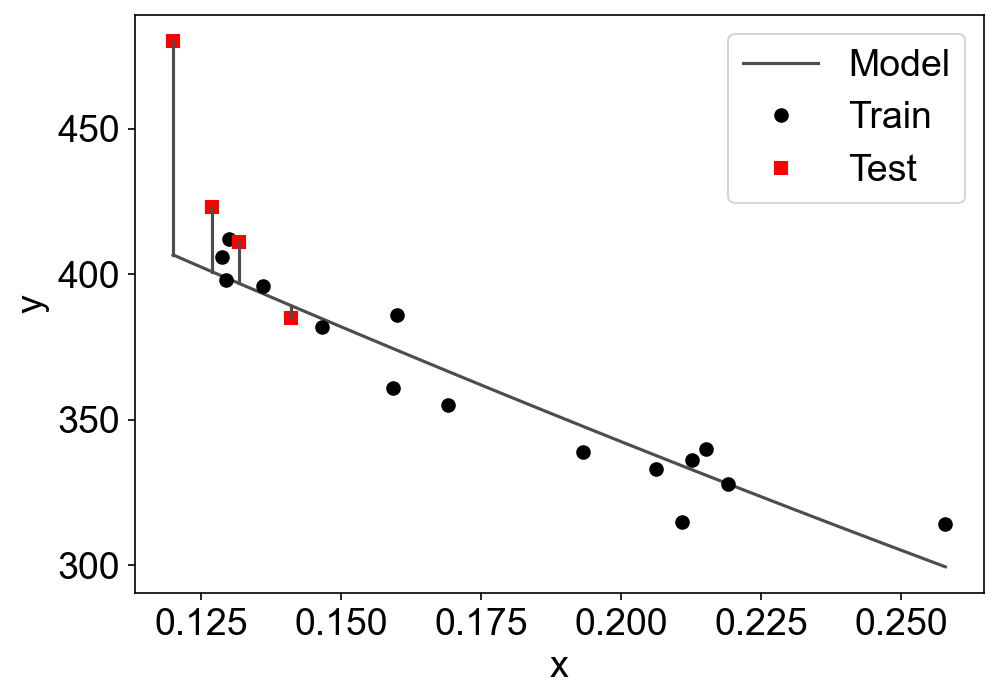

{'model': ElasticNet(),
 'rmse': 28.707285898079757,
 'rmse_std': 14.571357879463825,
 'baseline_rmse': 44.16226142683975,
 'baseline_rmse_std': 12.763778137139825,
 'corr': (-0.8800962628495023, -0.5886525571544494, -0.5335749381617668),
 'corr_std': (0.03255387555305136, 0.10344920971893344, 0.14662483271268137),
 'percent_error': 5.833642295025831,
 'percent_error_std': 2.542647921041017,
 'percent_error_train': 4.326650672546761,
 'percent_error_train_std': 0.47853139937238787,
 'r2_score': 0.05232628292970176,
 'r2_score_std': 1.2672346874691283,
 'r2_score_manual': 0.5774465417661756,
 'features': ('var_q_c20_c365_c3_ah',
  'var_q_c20_c56_c3_ah',
  'var_q_c20_c159_c3_ah')}

In [8]:
def train_and_test_model(df, xvars, yvar, 
                         to_plot=1, model=None, num_experiments=None,
                         log=False, square=False, sqrt=False):
    """
    Train and test a univariate linear regression model with cross-validation
    
    Args:
      df is a Pandas DataFrame object
      xvars is a list of strings (the feature names)
      yvar is a string (the label name)
      to_plot : make debug plots if true
      
    Returns:
      a dictionary holding model outputs
    """    
    # Fraction of samples reserved for model testing
    # e.g. 0.2 means 20% of samples reserved. In the 
    # context of cross-validation, this would be 
    # equivalent to a 5-fold cross-validation. The 
    # cross-validation we end up doing is not exactly
    # 5-fold cross-validation since we introduce random
    # sampling and many many repeats
    TEST_SIZE = 0.2
    
    # Number of trials
    num_experiments = num_experiments or 100
    
    # Unpack and filter data
    xvars = [xvars] if isinstance(xvars, str) else xvars
    # Create a temporary df to filter NaNs only from the columns we use
    xyvars = xvars + [yvar]
    df_nonans = df[xyvars].dropna()
    if log is True:
        df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))
    if square is True:
        df_nonans = df_nonans.apply(lambda x: x**2)
    if sqrt is True:
        df_nonans = df_nonans.apply(lambda x: np.sqrt(abs(x)))
    
    X = df_nonans[xvars].values
    y = df_nonans[yvar].values
        
    percent_error_list = []
    percent_error_train_list = []
    r2_score_list = []
    rmse_list = []
    baseline_rmse_list = []
    intercept_list = []
    coef_list = []
    corr_list = []
    
    has_plotted = 0
    
    for idx in range(num_experiments):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=TEST_SIZE)

        # apply standard scaler (fit only on train, transform both train and test)
        # keep originals for pltos
        X_train_original = X_train
        X_test_original = X_test
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
        (model, corr) = build_model(X_train, y_train, model)
        
        y_pred_train = model.predict(X_train)
        y_pred = model.predict(X_test)
        y_train_mean = np.mean(y_train)
        
        r2_score = model.score(X_test, y_test)
        
        if log is True:
            y_train = np.exp(y_train)
            y_pred_train = np.exp(y_pred_train)
            y_pred = np.exp(y_pred)
            y_test = np.exp(y_test)
            y_train_mean = np.exp(y_train_mean)
        if square is True:
            y_train = np.sqrt(y_train)
            y_pred_train = np.sqrt(y_pred_train)
            y_pred = np.sqrt(y_pred)
            y_test = np.sqrt(y_test)
            y_train_mean = np.sqrt(y_train_mean)
        if sqrt is True:
            y_train = (y_train)**2
            y_pred_train = (y_pred_train)**2
            y_pred = (y_pred)**2
            y_test = (y_test)**2
            y_train_mean = (y_train_mean)**2

        rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
        percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
        baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))
        percent_error_train = np.mean(np.abs(y_pred_train - y_train)/y_train) * 100
        
        rmse_list.append(rmse)
        percent_error_list.append(percent_error)
        percent_error_train_list.append(percent_error_train)
        r2_score_list.append(r2_score)
        baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
        corr_list.append(corr)
    
        # Give a visual into the cross-validation process
        if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
            has_plotted = 1
            
            x_fit = np.linspace(np.min(X), np.max(X), 100)
            x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
            y_fit = model.predict(x_fit_trans)
            if log is True:
                y_fit = np.exp(y_fit)
            if square is True:
                y_fit = np.sqrt(y_fit)
            if sqrt is True:
                y_fit = y_fit ** 2
            plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
            plt.plot(X_train_original, y_train, 'o', color='k')
            plt.plot(X_test_original, y_test, 's', color='r')
            
            for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
                plt.plot([this_x, this_x], 
                         [this_y, this_ypred], 
                         label='', color=(0.3, 0.3, 0.3))
                
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend(['Model', 'Train', 'Test'])
            plt.show()
    
    # Package the output
    final_model = model
    # Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)
        
    final_rmse = np.mean(rmse_list)
    final_rmse_std = np.std(rmse_list)
    
    final_baseline_rmse = np.mean(baseline_rmse_list)
    final_baseline_rmse_std = np.std(baseline_rmse_list)
    
    # Column mean and column std of a list of tuples
    final_corr = tuple(map(np.mean, zip(*corr_list)))
    final_corr_std = tuple(map(np.std, zip(*corr_list)))
    
    final_percent_error = np.mean(percent_error_list)
    final_percent_error_std = np.std(percent_error_list)
    final_percent_error_train = np.mean(percent_error_train_list)
    final_percent_error_train_std = np.std(percent_error_train_list)
    
#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
    final_r2_score = np.mean(r2_score_list)
    final_r2_score_std = np.std(r2_score_list)
    
    model_output_dict = dict()
    model_output_dict['model'] = final_model
    model_output_dict['rmse'] = final_rmse
    model_output_dict['rmse_std'] = final_rmse_std
    model_output_dict['baseline_rmse'] = final_baseline_rmse
    model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
    model_output_dict['corr'] = final_corr
    model_output_dict['corr_std'] = final_corr_std
    model_output_dict['percent_error'] = final_percent_error
    model_output_dict['percent_error_std'] = final_percent_error_std
    model_output_dict['percent_error_train'] = final_percent_error_train
    model_output_dict['percent_error_train_std'] = final_percent_error_train_std
    model_output_dict['r2_score'] = final_r2_score
    model_output_dict['r2_score_std'] = final_r2_score_std
    model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
    model_output_dict['features'] = tuple(xvars)
    
    return model_output_dict

# Test
# one feature
# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1)

# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1,
#                      log=True)

# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1,
#                      square=True)

train_and_test_model(df, 
                     "var_q_c20_c365_c3_ah", 
                     'cycles_to_80_pct', 
                     to_plot=1,
                     sqrt=True)

# multiple features
train_and_test_model(df, 
                     ["var_q_c20_c365_c3_ah", "var_q_c20_c56_c3_ah", "var_q_c20_c159_c3_ah"], 
                     'cycles_to_80_pct', 
                     to_plot=1,
                     model=ElasticNet())

# Single feature

## Set up and fit/predict/score

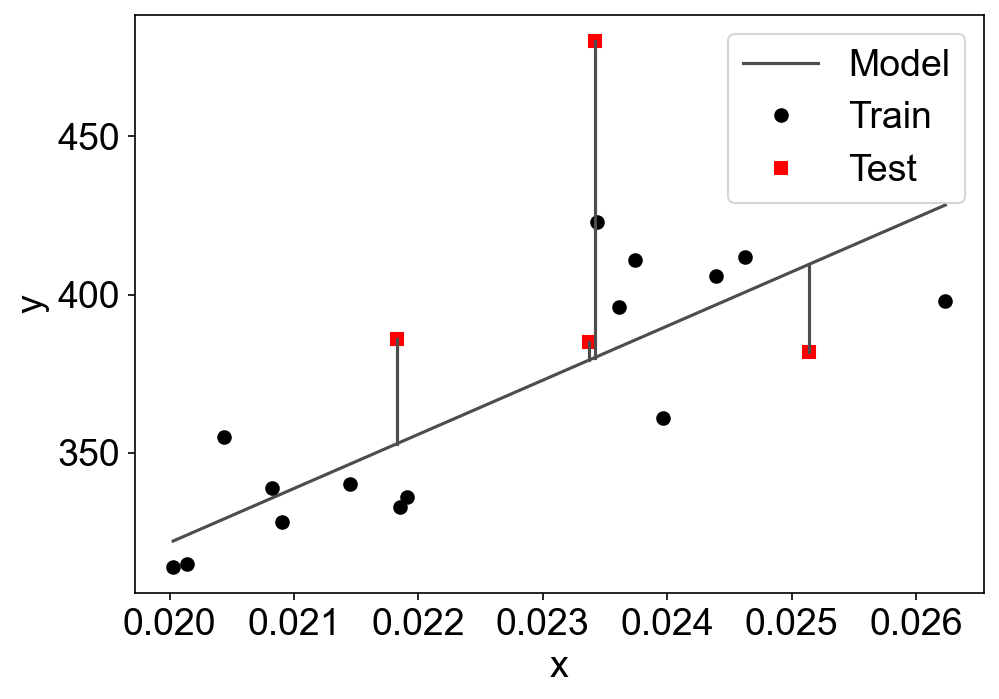

In [9]:
# Set the y-variable (the output the model is trying to predict)
yvar80 = 'cycles_to_80_pct'
yvar70 = 'cycles_to_70_pct'
yvar60 = 'cycles_to_60_pct'
yvar50 = 'cycles_to_50_pct'
yvar = yvar80

# Gather a list of modeled results. 
# Each element of the list holds all modeled results for a particular cycle
results_list = []

# First take care of the formation delta V signal, which only exists for the initial cycle
xvar = 'form_6hr_rest_delta_voltage_v'

model_output_dict = train_and_test_model(df, xvar, yvar)
model = model_output_dict['model']

results_dict = dict()
results_dict['cycle_index'] = 0 #
results_dict[xvar] = model_output_dict

results_list.append(results_dict)

Working on cycle 3...


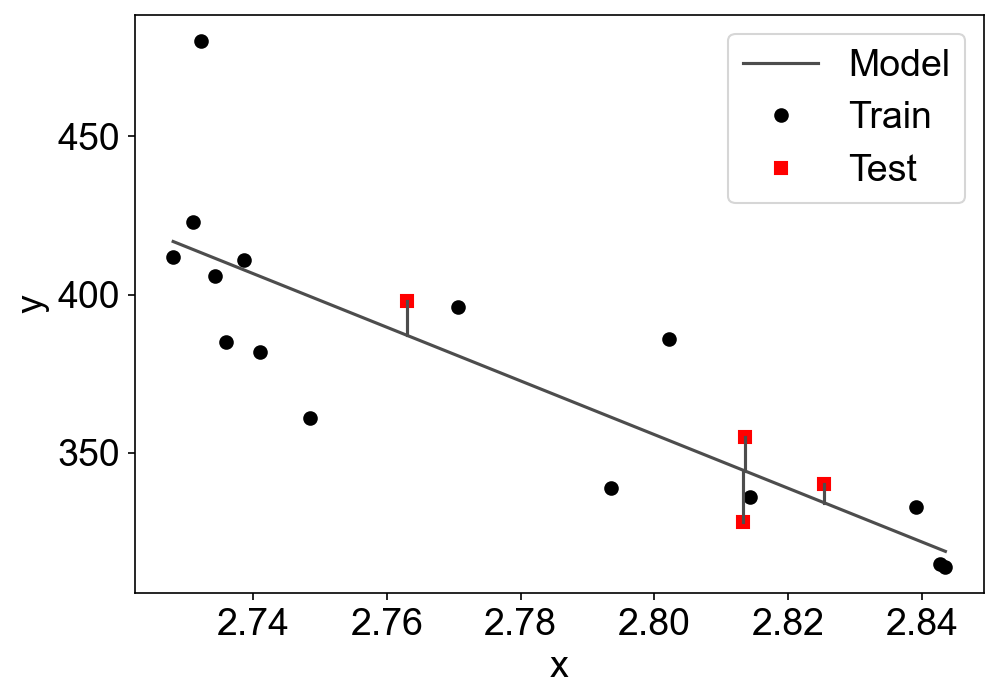

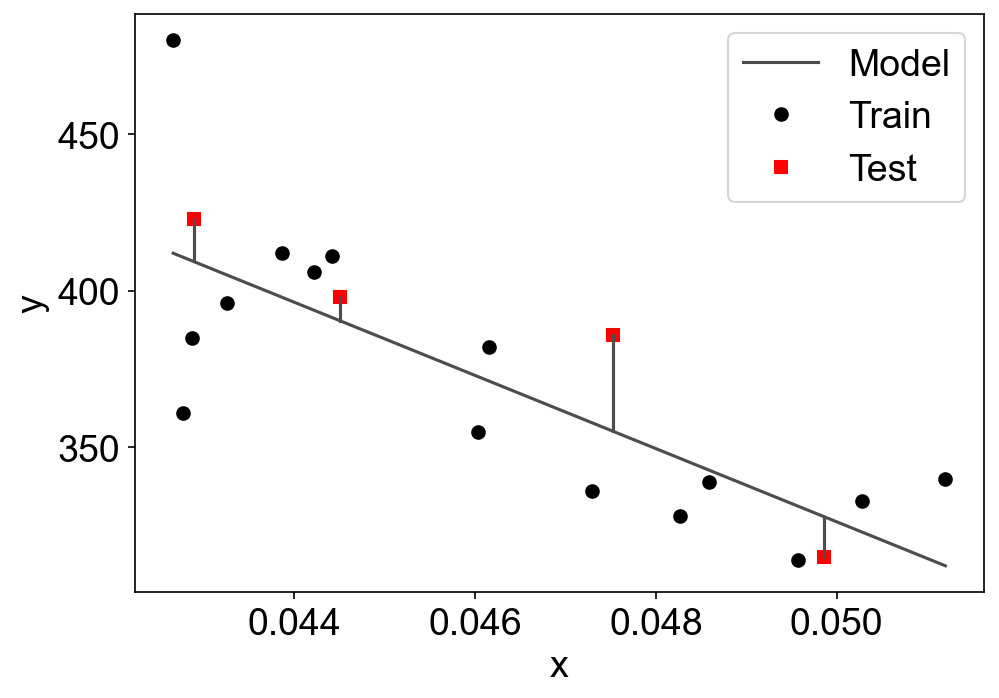

Working on cycle 56...


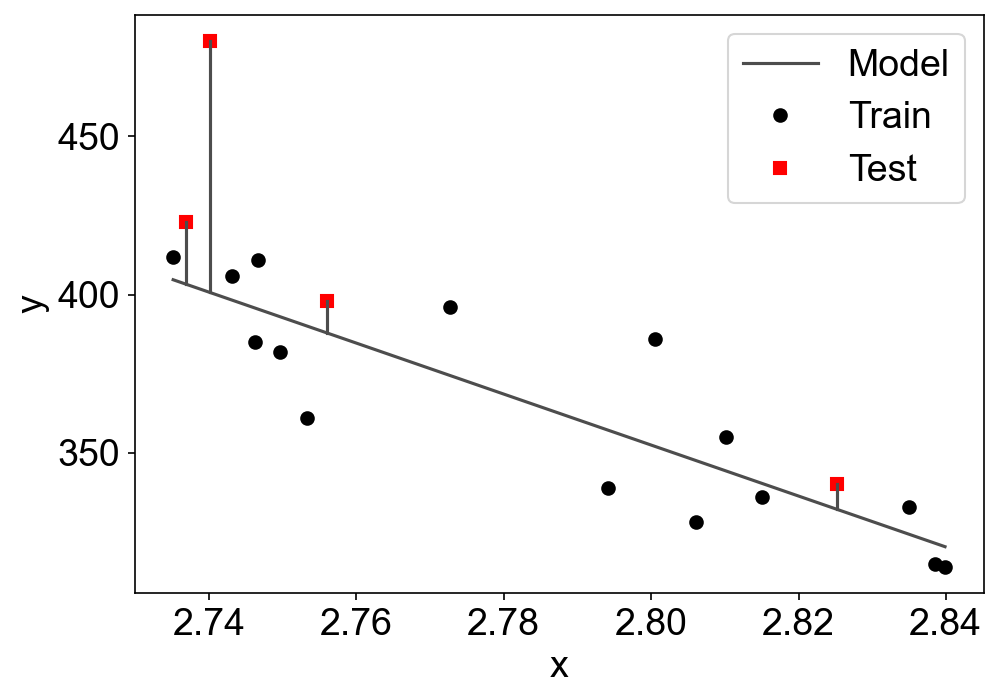

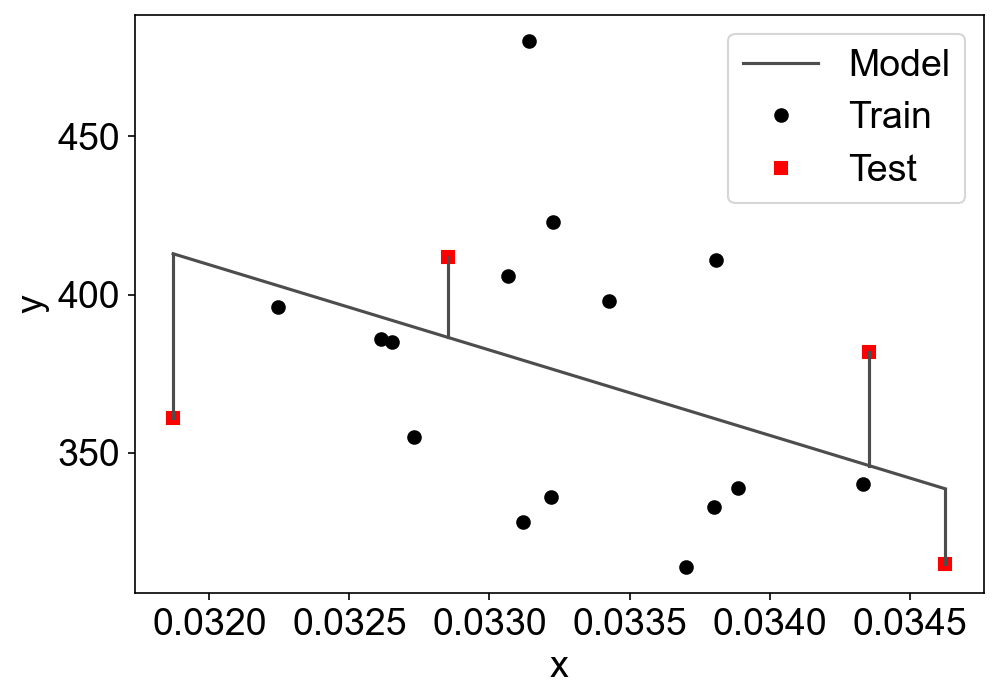

Working on cycle 159...


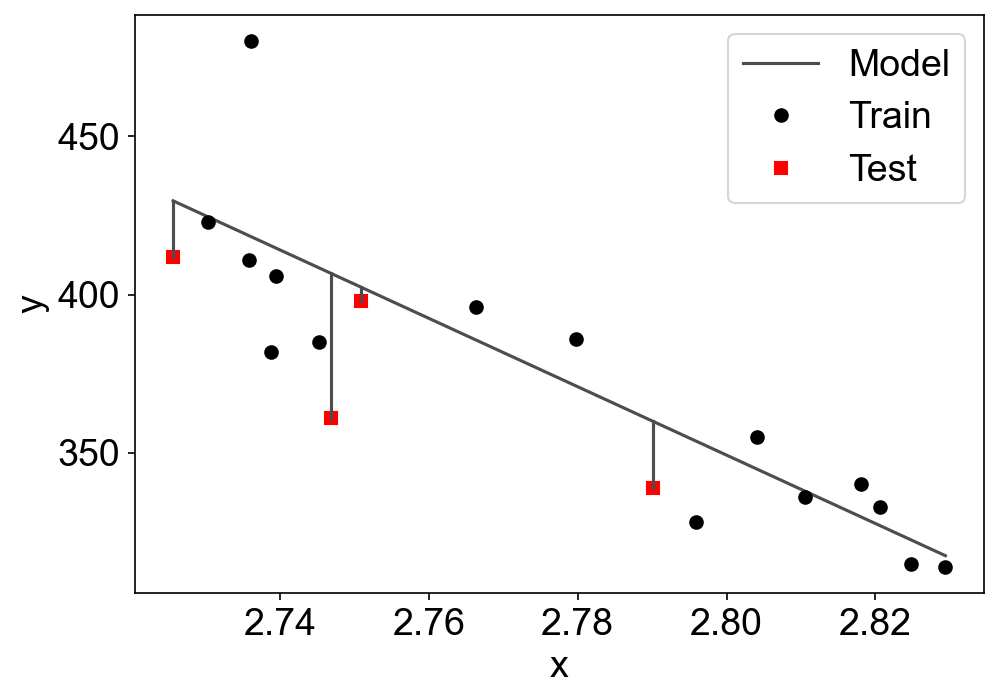

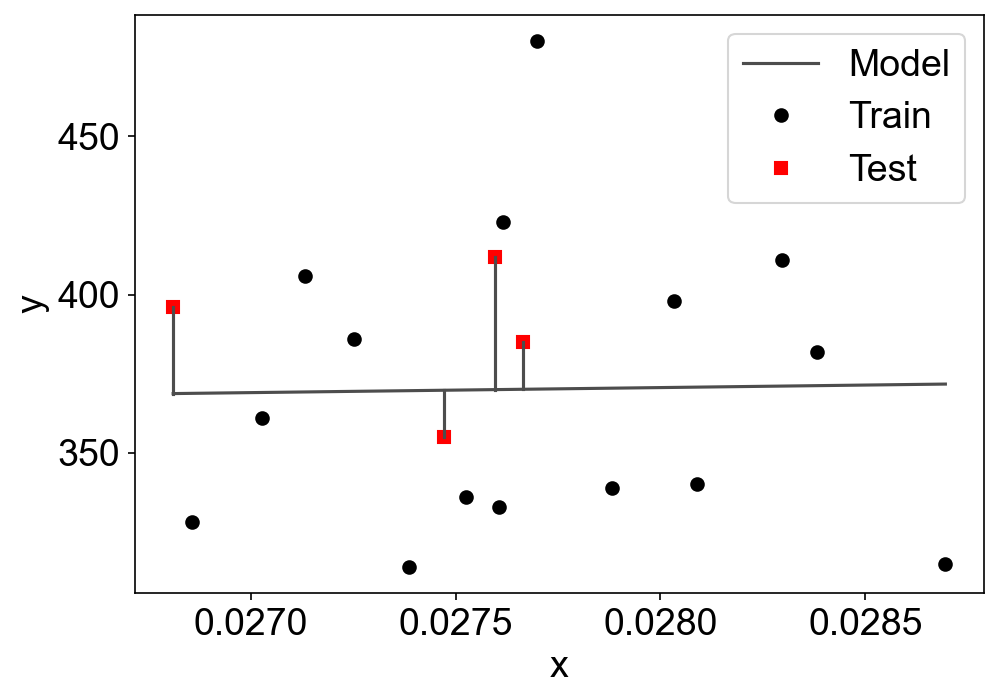

Working on cycle 262...


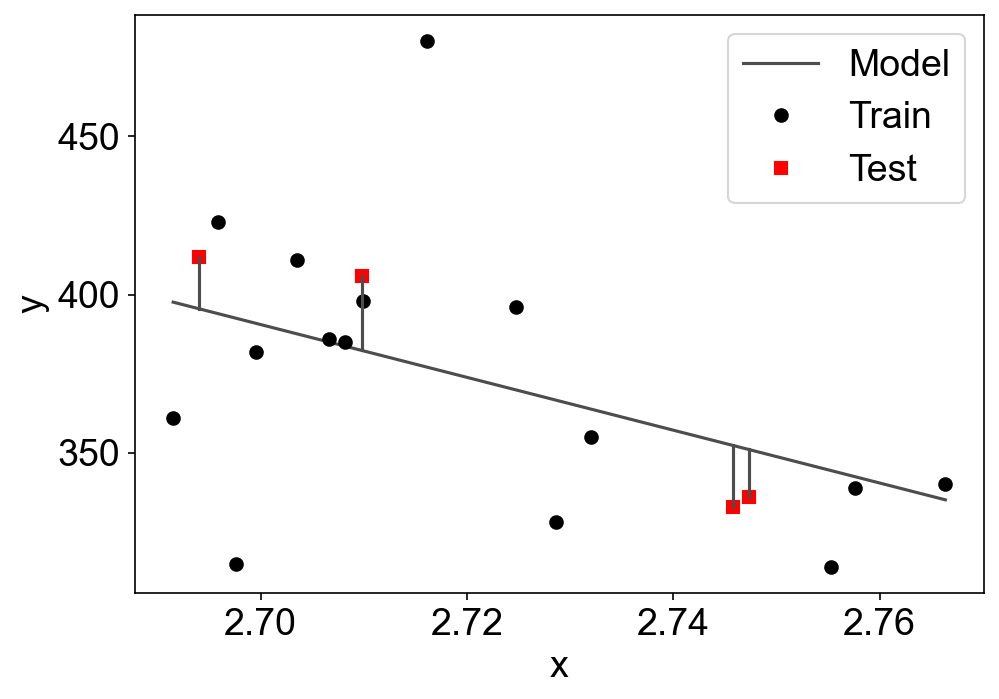

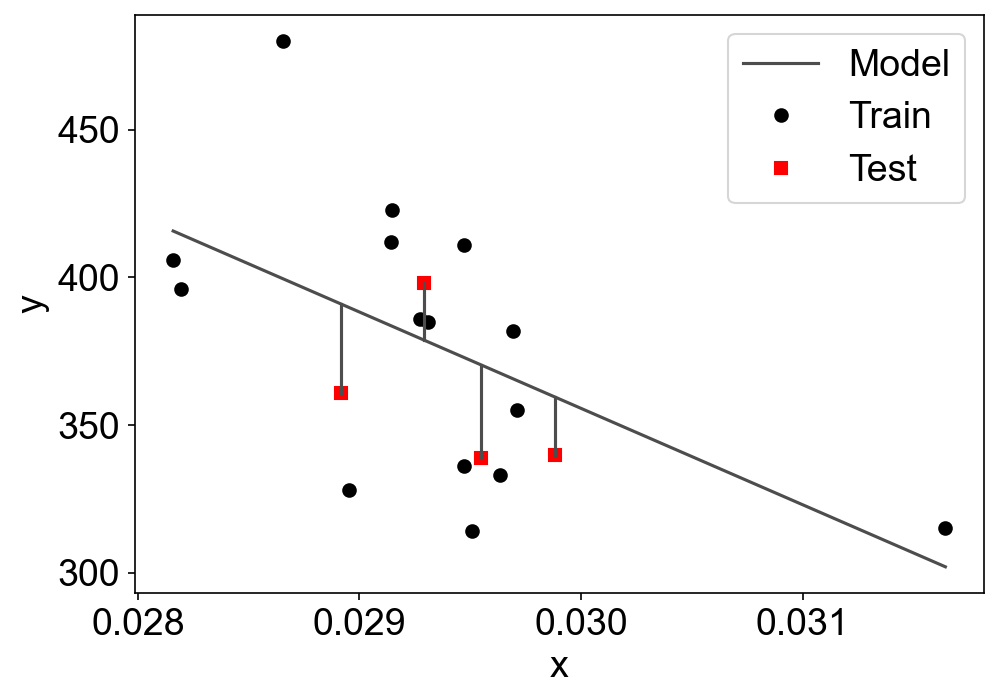

Working on cycle 365...


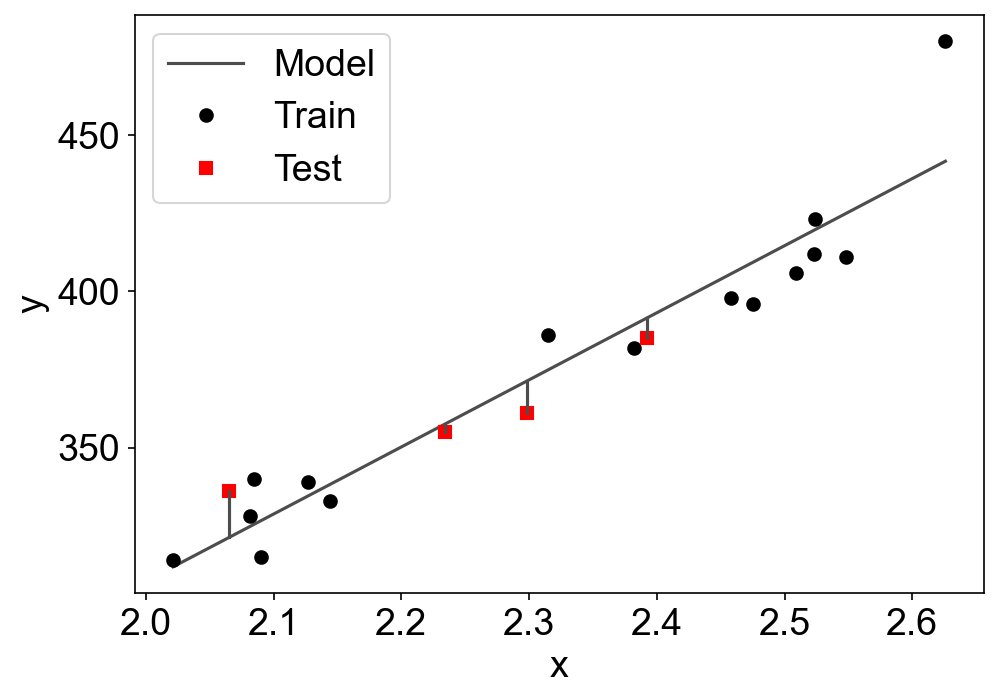

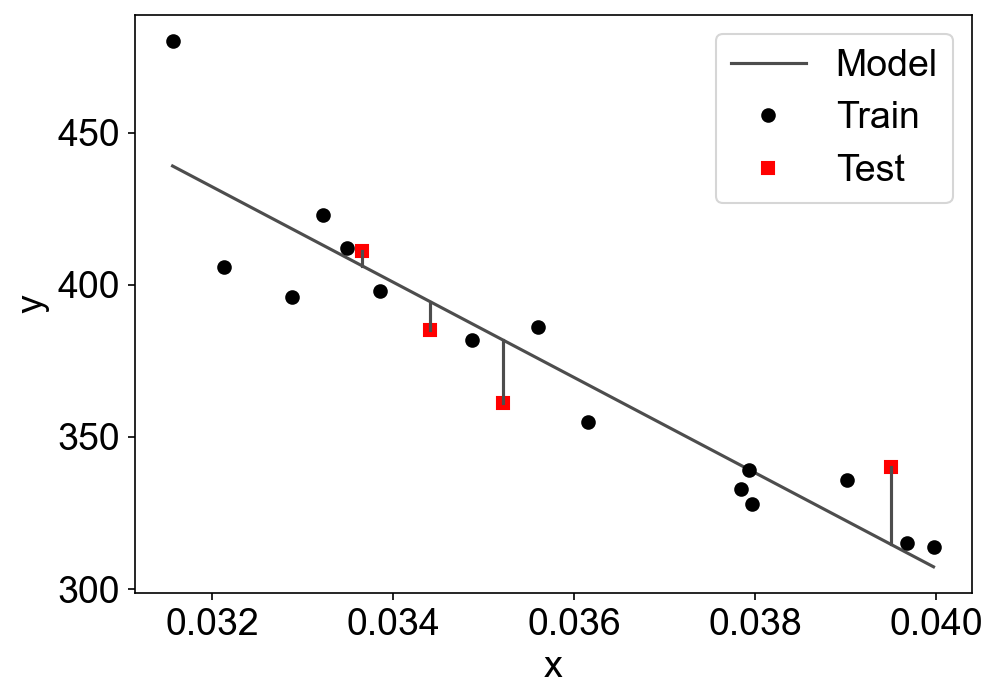

Done.


In [10]:
# Now take care of the rest of the signals. These signals exist for multiple cycles since 
# they exist at each RPT. So we will loop through the valid cycle indices and repeat this 
# process.

cycle_target_list = [3, 56, 159, 262, 365]

for cycle_idx in cycle_target_list:
    
    print(f'Working on cycle {cycle_idx}...')
    
    # Assemble x variables of interest
    xvar_array = [f'esoh_c{cycle_idx}_Cn',
                  f'dcr_10s_5_soc_at_c{cycle_idx}',
                  f'var_q_c{cycle_idx}_c3']
    
    results_dict = dict()
    results_dict['cycle_index'] = cycle_idx
    
    # Loop over x-variables
    for xvar in xvar_array:

        if not xvar in df.columns:
            continue
        
        model_output_dict = train_and_test_model(df, xvar, yvar)
        
        model = model_output_dict['model']

        if '_Cn' in xvar:
            xvar_label = 'Cn'
        if 'dcr_10s_5_soc' in xvar:
            xvar_label = 'dcr_10s_5_soc'
        if 'var_q' in xvar:
            xvar_label = 'var_q'
    
        results_dict[xvar_label] = model_output_dict
        
    results_list.append(results_dict)      
    
print('Done.')
    

Take a look at the results list variable.

It is a list of dictionaries. Each dictionary holds the output for a single cycle index.

In [11]:
results_list

[{'cycle_index': 0,
  'form_6hr_rest_delta_voltage_v': {'model': LinearRegression(),
   'rmse': 30.401615920404847,
   'rmse_std': 13.07762265170446,
   'baseline_rmse': 41.350365377991494,
   'baseline_rmse_std': 12.557347773578718,
   'corr': (0.7052518594298899,),
   'corr_std': (0.05687967526096266,),
   'percent_error': 6.485410227551426,
   'percent_error_std': 2.237348831903024,
   'percent_error_train': 5.814242627997541,
   'percent_error_train_std': 0.6022885579612215,
   'r2_score': -0.5711118730203466,
   'r2_score_std': 4.053476088130486,
   'r2_score_manual': 0.4594515413870952,
   'features': ('form_6hr_rest_delta_voltage_v',)}},
 {'cycle_index': 3,
  'Cn': {'model': LinearRegression(),
   'rmse': 22.51121401133452,
   'rmse_std': 10.921817534632842,
   'baseline_rmse': 43.80916384413451,
   'baseline_rmse_std': 13.018272071293552,
   'corr': (-0.844643065472607,),
   'corr_std': (0.0339123131680467,),
   'percent_error': 4.723949069154165,
   'percent_error_std': 1.8557

## Re-package the data to become easily plottable

Repackage the data to index by feature, which makes it easier for plotting.

There is probably a more "pandas-y" way to do this.

In [12]:
# Get a list of unique x-variable labels
unique_keys = set()
for result_dict in results_list:
    for key in result_dict.keys():
        unique_keys.add(key)
unique_keys.remove('cycle_index')

# Assemble the outputs into a dictionary
output_dict = dict()
for key in unique_keys:
    
    cycle_list = []
    rmse_list = []
    rmse_std_list = []
    corr_list = []
    corr_std_list = []
    percent_error_list = []
    percent_error_std_list = []
    
    for result_dict in results_list:

        cycle_list.append(result_dict['cycle_index'])    
        
        if not key in result_dict:
            rmse_list.append(np.nan)
            rmse_std_list.append(np.nan)
            corr_list.append(np.nan)
            corr_std_list.append(np.nan)
            percent_error_list.append(np.nan)
            percent_error_std_list.append(np.nan)
            continue

        rmse_list.append(result_dict[key]['rmse'])
        rmse_std_list.append(result_dict[key]['rmse_std'])
        if len(result_dict[key]['corr']) == 1:
            corr_list.append(result_dict[key]['corr'][0])
            corr_std_list.append(result_dict[key]['corr_std'][0])
        percent_error_list.append(result_dict[key]['percent_error'])
        percent_error_std_list.append(result_dict[key]['percent_error_std'])
        
        
    this_result = dict()
    this_result['cycle_index'] = cycle_list
    this_result['rmse'] = rmse_list
    this_result['rmse_std'] = rmse_std_list
    this_result['corr'] = corr_list
    this_result['corr_std'] = corr_std_list
    this_result['percent_error'] = percent_error_list
    this_result['percent_error_std'] = percent_error_std_list
    
    output_dict[key] = this_result
    
# The output dictionary is now indexed by feature
output_dict

{'Cn': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [nan,
   22.51121401133452,
   22.366330311937478,
   22.958878868790503,
   33.90388075929477,
   14.07598915969239],
  'rmse_std': [nan,
   10.921817534632842,
   11.082781886176077,
   12.047985713693421,
   17.47846389033855,
   7.20431533222738],
  'corr': [nan,
   -0.844643065472607,
   -0.8498192681060498,
   -0.8592298566948305,
   -0.5402914733918395,
   0.9583598967511995],
  'corr_std': [nan,
   0.0339123131680467,
   0.03403950314571045,
   0.034833138029480216,
   0.08811409299043033,
   0.01131829315615604],
  'percent_error': [nan,
   4.723949069154165,
   4.656028063965924,
   4.58286519763422,
   7.324547845807534,
   2.8945582474955023],
  'percent_error_std': [nan,
   1.8557860596335223,
   1.9033983764832698,
   1.9365172480152864,
   3.5656761293943866,
   0.9814924487962218]},
 'dcr_10s_5_soc': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [nan,
   29.81652250632778,
   41.94758886829265,
   48.237

## Visualize the results

In [13]:
# Create another dictionary of labels
label_dict = dict()
label_dict['var_q'] = '$\Delta Q$'
label_dict['Cn'] = '$C_n$'
label_dict['dcr_10s_5_soc'] = '$R_{10s, 5\%SOC}$'
label_dict['form_6hr_rest_delta_voltage_v'] = '$\Delta V_{rest, 6hr}$'

# Multiple features from formation

## Data analysis

In [14]:
yvar = yvar70

Select relevant formation features

In [15]:
form_select = lambda x: x.startswith("form_") and "trace" not in x and "rebound" not in x
form_features = list(filter(form_select, df.columns))
label_select = lambda x: x.startswith("cycles_to_")
labels = list(filter(label_select, df.columns))
df_form = df[form_features + labels]
df_form.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 33 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   form_first_discharge_capacity_below_3p2v_ah  19 non-null     float64
 1   form_last_charge_voltage_after_1s            19 non-null     float64
 2   form_last_charge_voltage_after_10s           19 non-null     float64
 3   form_last_charge_voltage_after_60s           19 non-null     float64
 4   form_first_charge_capacity_ah                19 non-null     float64
 5   form_first_discharge_capacity_ah             19 non-null     float64
 6   form_first_cycle_efficiency                  19 non-null     float64
 7   form_final_discharge_capacity_ah             19 non-null     float64
 8   form_6hr_rest_delta_voltage_v_0_to_1_hr      19 non-null     float64
 9   form_6hr_rest_delta_voltage_v_0_to_2_hr      19 non-null     float64
 10  form

In [16]:
df_form_sq = df_form.apply(lambda x: x**2).rename(lambda s: s + "_squared", axis="columns")
df_form_sq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 33 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   form_first_discharge_capacity_below_3p2v_ah_squared  19 non-null     float64
 1   form_last_charge_voltage_after_1s_squared            19 non-null     float64
 2   form_last_charge_voltage_after_10s_squared           19 non-null     float64
 3   form_last_charge_voltage_after_60s_squared           19 non-null     float64
 4   form_first_charge_capacity_ah_squared                19 non-null     float64
 5   form_first_discharge_capacity_ah_squared             19 non-null     float64
 6   form_first_cycle_efficiency_squared                  19 non-null     float64
 7   form_final_discharge_capacity_ah_squared             19 non-null     float64
 8   form_6hr_rest_delta_voltage_v_0_to_1_hr_squared      19 non-null     flo

In [17]:
df_form_plus_sq = pd.concat([df_form, df_form_sq], axis=1)
df_form_plus_sq.head()

form_first_discharge_capacity_below_3p2v_ah  \
0                                     0.077820   
1                                     0.073791   
2                                     0.074725   
3                                     0.069433   
4                                     0.073127   

   form_last_charge_voltage_after_1s  form_last_charge_voltage_after_10s  \
0                           3.393505                            3.403936   
1                           3.401924                            3.412256   
2                           3.398755                            3.409052   
3                           3.400189                            3.410498   
4                           3.396888                            3.407243   

   form_last_charge_voltage_after_60s  form_first_charge_capacity_ah  \
0                            3.420587                       2.755302   
1                            3.428007                       2.698299   
2                            3.424840                       2.713403   
3                            3.426320                       2.696613   
4                            3.423244                       2.713639   

   form_first_discharge_capacity_ah  form_first_cycle_efficiency  \
0                          2.312734                     0.839376   
1                          2.313851                     0.857522   
2                          2.309945                     0.851309   
3                          2.310417                     0.856785   
4                          2.330587                     0.858842   

   form_final_discharge_capacity_ah  form_6hr_rest_delta_voltage_v_0_to_1_hr  \
0                          2.367225                                 0.011104   
1                          2.363418                                 0.010694   
2                          2.362668                                 0.011531   
3                          2.356018                                 0.010730   
4                          2.381257                                 0.011573   

   form_6hr_rest_delta_voltage_v_0_to_2_hr  \
0                                 0.014412   
1                                 0.013741   
2                                 0.015044   
3                                 0.013928   
4                                 0.015010   

   form_6hr_rest_delta_voltage_v_0_to_3_hr  \
0                                 0.016395   
1                                 0.015612   
2                                 0.017074   
3                                 0.015780   
4                                 0.017089   

   form_6hr_rest_delta_voltage_v_0_to_4_hr  \
0                                 0.017794   
1                                 0.017002   
2                                 0.018645   
3                                 0.017201   
4                                 0.018494   

   form_6hr_rest_delta_voltage_v_0_to_5_hr  \
0                                 0.018984   
1                                 0.018085   
2                                 0.019790   
3                                 0.018138   
4                                 0.019764   

   form_6hr_rest_delta_voltage_v_0_to_6_hr  \
0                                 0.019909   
1                                 0.018962   
2                                 0.020716   
3                                 0.019097   
4                                 0.020793   

   form_6hr_rest_delta_voltage_v_1_to_6_hr  \
0                                 0.008731   
1                                 0.008188   
2                                 0.009108   
3                                 0.008275   
4                                 0.009128   

   form_6hr_rest_delta_voltage_v_2_to_6_hr  \
0                                 0.005468   
1                                 0.005158   
2                                 0.005626   
3                                 0.005127   
4                             

Look for correlations

In [18]:
df_form.corr()[yvar50].sort_values(ascending=False)

cycles_to_50_pct                               1.000000
cycles_to_60_pct                               0.995579
cycles_to_70_pct                               0.976940
cycles_to_80_pct                               0.971337
form_last_charge_voltage_after_60s             0.802370
form_c20_charge_right_peak_v_per_ah            0.772470
form_6hr_rest_delta_voltage_v_0_to_3_hr        0.730636
form_6hr_rest_delta_voltage_v_0_to_4_hr        0.729484
form_6hr_rest_delta_voltage_v_0_to_5_hr        0.726760
form_6hr_rest_delta_voltage_v_0_to_2_hr        0.721277
form_6hr_rest_delta_voltage_v_0_to_6_hr        0.711559
form_6hr_rest_delta_voltage_v                  0.710422
form_6hr_rest_delta_voltage_v_0_to_1_hr        0.698247
form_6hr_rest_delta_voltage_v_1_to_6_hr        0.651170
form_6hr_rest_delta_voltage_v_2_to_6_hr        0.565207
form_6hr_rest_delta_voltage_v_3_to_6_hr        0.505149
form_6hr_rest_delta_voltage_v_4_to_6_hr        0.467371
form_6hr_rest_delta_voltage_v_5_to_6_hr        0

Select and plot features with abs(corr) > 0.6

In [19]:
high_corr = lambda name: abs(df_form.corr()[yvar][name]) > 0.6
high_corr_form_features = list(filter(high_corr, form_features))
high_corr_form_features

['form_first_discharge_capacity_below_3p2v_ah',
 'form_last_charge_voltage_after_1s',
 'form_last_charge_voltage_after_10s',
 'form_last_charge_voltage_after_60s',
 'form_first_discharge_capacity_ah',
 'form_first_cycle_efficiency',
 'form_6hr_rest_delta_voltage_v_0_to_1_hr',
 'form_6hr_rest_delta_voltage_v_0_to_2_hr',
 'form_6hr_rest_delta_voltage_v_0_to_3_hr',
 'form_6hr_rest_delta_voltage_v_0_to_4_hr',
 'form_6hr_rest_delta_voltage_v_0_to_5_hr',
 'form_6hr_rest_delta_voltage_v_0_to_6_hr',
 'form_6hr_rest_delta_voltage_v_1_to_6_hr',
 'form_c20_charge_right_peak_v_per_ah',
 'form_6hr_rest_delta_voltage_v',
 'form_6hr_rest_voltage_v',
 'form_6hr_rest_mv_per_sec_initial']

In [20]:
very_high_corr = lambda name: abs(df_form.corr()[yvar][name]) > 0.77
very_high_corr_form_features = list(filter(very_high_corr, form_features))
very_high_corr_form_features

['form_first_discharge_capacity_below_3p2v_ah',
 'form_last_charge_voltage_after_1s',
 'form_last_charge_voltage_after_60s',
 'form_first_discharge_capacity_ah',
 'form_first_cycle_efficiency',
 'form_c20_charge_right_peak_v_per_ah']

In [21]:
df_form[high_corr_form_features].corr()["form_first_discharge_capacity_ah"].sort_values()

form_last_charge_voltage_after_60s            -0.980428
form_6hr_rest_delta_voltage_v_0_to_3_hr       -0.916951
form_6hr_rest_delta_voltage_v_0_to_2_hr       -0.915978
form_6hr_rest_delta_voltage_v_0_to_4_hr       -0.913766
form_6hr_rest_delta_voltage_v_0_to_1_hr       -0.904858
form_6hr_rest_delta_voltage_v_0_to_5_hr       -0.903710
form_c20_charge_right_peak_v_per_ah           -0.898403
form_6hr_rest_delta_voltage_v_0_to_6_hr       -0.893952
form_6hr_rest_delta_voltage_v                 -0.890137
form_6hr_rest_delta_voltage_v_1_to_6_hr       -0.789071
form_6hr_rest_mv_per_sec_initial               0.871221
form_6hr_rest_voltage_v                        0.890137
form_last_charge_voltage_after_10s             0.937693
form_first_discharge_capacity_below_3p2v_ah    0.994841
form_last_charge_voltage_after_1s              0.998766
form_first_cycle_efficiency                    0.999884
form_first_discharge_capacity_ah               1.000000
Name: form_first_discharge_capacity_ah, dtype: f

<ipython-input-22-d77f4693741f>:11: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
<ipython-input-22-d77f4693741f>:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")
<ipython-input-22-d77f4693741f>:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")
/Users/aweng/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


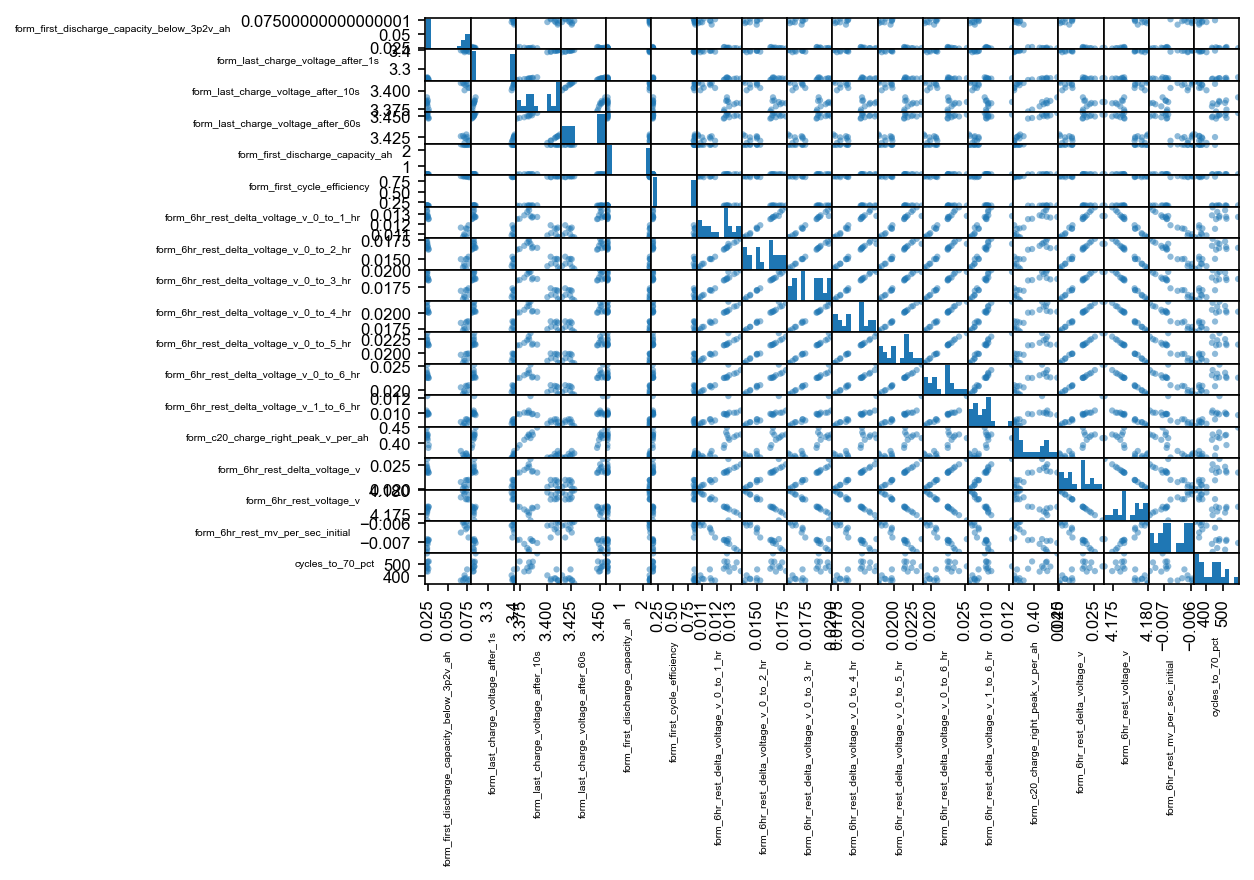

In [22]:
from pandas.plotting import scatter_matrix
plt.rcParams['axes.labelsize'] = 5
axes = scatter_matrix(df_form[high_corr_form_features + [yvar]])

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    
OUTPUT_DIR = "code-base/imgs/"
plt.tight_layout()
plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")

In [23]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
config_plots()

### with log

In [24]:
df_form_log = df_form.apply(lambda x: np.log(abs(x)))
df_form_log.describe()

form_first_discharge_capacity_below_3p2v_ah  \
count                                    19.000000   
mean                                     -3.198979   
std                                       0.564067   
min                                      -3.766923   
25%                                      -3.729466   
50%                                      -3.649625   
75%                                      -2.626924   
max                                      -2.553354   

       form_last_charge_voltage_after_1s  form_last_charge_voltage_after_10s  \
count                          19.000000                           19.000000   
mean                            1.198703                            1.222002   
std                             0.023588                            0.004068   
min                             1.174555                            1.215440   
25%                             1.177094                            1.218782   
50%                             1.179177                            1.221083   
75%                             1.223027                            1.226052   
max                             1.224341                            1.227374   

       form_last_charge_voltage_after_60s  form_first_charge_capacity_ah  \
count                           19.000000                      19.000000   
mean                             1.234841                       1.003142   
std                              0.004154                       0.012057   
min                              1.228971                       0.988929   
25%                              1.231004                       0.994866   
50%                              1.237599                       0.998291   
75%                              1.238623                       1.009378   
max                              1.239590                       1.037936   

       form_first_discharge_capacity_ah  form_first_cycle_efficiency  \
count                         19.000000                    19.000000   
mean                           0.008368                    -0.994774   
std                            0.812216                     0.816364   
min                           -0.759595                    -1.784166   
25%                           -0.741329                    -1.746586   
50%                           -0.728661                    -1.722820   
75%                            0.838672                    -0.157774   
max                            0.850454                    -0.140043   

       form_final_discharge_capacity_ah  \
count                         19.000000   
mean                           0.860630   
std                            0.004333   
min                            0.854034   
25%                            0.858194   
50%                            0.860109   
75%                            0.862090   
max                            0.869140   

       form_6hr_rest_delta_voltage_v_0_to_1_hr  \
count                                19.000000   
mean                                 -4.416723   
std                                   0.078911   
min                                  -4.538118   
25%                                  -4.481583   
50%                                  -4.382669   
75%                                  -4.360943   
max                                  -4.293166   

       form_6hr_rest_delta_voltage_v_0_to_2_hr  \
count                                19.000000   
mean                                 -4.154705   
std                                   0.081232   
min                                  -4.287379   
25%                                  -4.219624   
50%                                  -4.119745   
75%                                  -4.093166   
max                                  -4.035049   

       form_6hr_rest_delta_voltage_v_0_to_3_hr  \
count                                19.000000   
mean                                 -4.027465   
std                      

In [25]:
df_form_log.corr()[yvar].sort_values(ascending=False)

cycles_to_70_pct                               1.000000
cycles_to_60_pct                               0.983852
cycles_to_80_pct                               0.978925
cycles_to_50_pct                               0.973508
form_last_charge_voltage_after_60s             0.834031
form_c20_charge_right_peak_v_per_ah            0.808079
form_6hr_rest_delta_voltage_v_0_to_3_hr        0.775806
form_6hr_rest_delta_voltage_v_0_to_4_hr        0.770741
form_6hr_rest_delta_voltage_v_0_to_2_hr        0.770716
form_6hr_rest_delta_voltage_v_0_to_5_hr        0.764190
form_6hr_rest_delta_voltage_v_0_to_1_hr        0.751677
form_6hr_rest_delta_voltage_v_0_to_6_hr        0.749858
form_6hr_rest_delta_voltage_v                  0.747567
form_6hr_rest_mv_per_sec_initial               0.707107
form_6hr_rest_delta_voltage_v_1_to_6_hr        0.689184
form_6hr_rest_delta_voltage_v_2_to_6_hr        0.604837
form_6hr_rest_delta_voltage_v_3_to_6_hr        0.541764
form_6hr_rest_delta_voltage_v_4_to_6_hr        0

## Training a regularized model

### Individual features

In [26]:
from sklearn.dummy import DummyRegressor

In [27]:
for f in form_features:
    out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000)
    print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000)
print(f"{'Dummy regressor (predict mean)':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
# train_and_test_model(df, form_features, yvar, to_plot=0, model=Ridge())
# model = ElasticNet(0.01, l1_ratio=0.5)
# train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
# print(model.coef_)

form_first_discharge_capacity_below_3p2v_ah       7.61 (2.50 std)
form_last_charge_voltage_after_1s                 7.54 (2.51 std)
form_last_charge_voltage_after_10s                8.79 (2.67 std)
form_last_charge_voltage_after_60s                7.79 (2.63 std)
form_first_charge_capacity_ah                     14.12 (3.93 std)
form_first_discharge_capacity_ah                  7.44 (2.42 std)
form_first_cycle_efficiency                       7.30 (2.42 std)
form_final_discharge_capacity_ah                  12.87 (4.27 std)
form_6hr_rest_delta_voltage_v_0_to_1_hr           9.16 (3.21 std)
form_6hr_rest_delta_voltage_v_0_to_2_hr           8.76 (3.02 std)
form_6hr_rest_delta_voltage_v_0_to_3_hr           8.60 (2.86 std)
form_6hr_rest_delta_voltage_v_0_to_4_hr           8.77 (2.73 std)
form_6hr_rest_delta_voltage_v_0_to_5_hr           9.11 (2.71 std)
form_6hr_rest_delta_voltage_v_0_to_6_hr           9.48 (2.88 std)
form_6hr_rest_delta_voltage_v_1_to_6_hr           11.44 (3.84 std)
form_6h

with log

In [28]:
for f in form_features:
    out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000, log=True)
    print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000, log=True)
print(f"{'Dummy regressor (predict mean)':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")


form_first_discharge_capacity_below_3p2v_ah       7.55 (2.48 std)
form_last_charge_voltage_after_1s                 7.29 (2.53 std)
form_last_charge_voltage_after_10s                8.38 (2.97 std)
form_last_charge_voltage_after_60s                7.57 (2.59 std)
form_first_charge_capacity_ah                     13.98 (3.92 std)
form_first_discharge_capacity_ah                  7.26 (2.48 std)
form_first_cycle_efficiency                       7.37 (2.46 std)
form_final_discharge_capacity_ah                  12.96 (4.17 std)
form_6hr_rest_delta_voltage_v_0_to_1_hr           9.13 (3.13 std)
form_6hr_rest_delta_voltage_v_0_to_2_hr           8.85 (3.10 std)
form_6hr_rest_delta_voltage_v_0_to_3_hr           8.50 (2.91 std)
form_6hr_rest_delta_voltage_v_0_to_4_hr           8.80 (2.91 std)
form_6hr_rest_delta_voltage_v_0_to_5_hr           8.90 (2.78 std)
form_6hr_rest_delta_voltage_v_0_to_6_hr           9.26 (2.81 std)
form_6hr_rest_delta_voltage_v_1_to_6_hr           10.80 (4.40 std)
form_6h

### Manual hyperparameter loops

In [29]:
def manual_gridsearch(features, yvar, log=False):
    gridsearch = {}
    def ridge(alpha):
        return train_and_test_model(df, features, yvar, to_plot=0, model=Ridge(alpha), log=log)["percent_error"]

    alphas = np.logspace(0,2,20)
    gridsearch["Ridge"] = (alphas, list(map(ridge, alphas)))
    
    def lasso(alpha):
        return train_and_test_model(df, features, yvar, to_plot=0, model=Lasso(alpha), log=log)["percent_error"]

    alphas = np.logspace(0,2,20)
    gridsearch["Lasso"] = (alphas, list(map(lasso, alphas)))
    
    def elastic_net(alpha, l1_ratio):
        return train_and_test_model(df, features, yvar, to_plot=0, 
                                    model=ElasticNet(alpha, l1_ratio=l1_ratio), log=log)["percent_error"]

    N = 10
    alphas = np.logspace(0,2,N)
    l1_ratios = np.linspace(0,1,N)
    errors = np.empty((N,N))
    for i, alpha in enumerate(alphas):
        print(i)
        for j, l1_ratio in enumerate(l1_ratios):
            errors[i,j] = elastic_net(alpha, l1_ratio)
    gridsearch["ElasticNet"] = (alphas, l1_ratios, errors)
    
    return gridsearch

In [30]:
gridsearch = manual_gridsearch(form_features, yvar70)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.082044513450455, tolerance: 6.8453599999999994
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.114318227168951, tolerance: 7.4976
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.297979319287151, tolerance: 6.388533333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

0


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13555.89231257777, tolerance: 7.568933333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14558.63042816949, tolerance: 6.635573333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9955.948756702146, tolerance: 8.090133333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13517.76621353842, tolerance: 6.4217733333333324
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9614.196598210558, tolerance: 6.990293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13819.454810818308, tolerance: 7.130559999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13590.012505191087, tolerance: 7.831573333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12775.330120442171, tolerance: 7.091040000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13215.791153193113, tolerance: 6.097933333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.534842200716412, tolerance: 5.102693333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.397401015227842, tolerance: 5.487333333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.30600813897763, tolerance: 5.4981599999999995
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15119.775425228436, tolerance: 7.480893333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13652.486013361693, tolerance: 7.30256
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16687.70573311964, tolerance: 7.094293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15478.78183761391, tolerance: 7.626560000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12965.249664258798, tolerance: 7.942293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15059.380345250282, tolerance: 8.090693333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11501.376401991038, tolerance: 5.61884
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16078.61911079222, tolerance: 7.881493333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8536.652995706483, tolerance: 5.903733333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16671.973137854835, tolerance: 7.798933333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15604.27330983575, tolerance: 7.3689599999999995
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16770.99488345926, tolerance: 6.677973333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18173.712484396896, tolerance: 7.713893333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17966.43928910869, tolerance: 7.428400000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16942.392156011287, tolerance: 7.460173333333331
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.778576854896528, tolerance: 5.805173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.77857685490926, tolerance: 5.805173333333333
  model = cd_fast.enet_coordinate_descent(


3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18051.53361260354, tolerance: 7.942559999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19533.82077739245, tolerance: 6.973173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19396.9885867154, tolerance: 7.9138399999999995
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19827.875762531807, tolerance: 7.275973333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19327.45146327148, tolerance: 7.114959999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17368.992970055704, tolerance: 7.009973333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18048.580362451612, tolerance: 7.000773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20188.26067239801, tolerance: 7.941893333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11763.089079245685, tolerance: 4.967493333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21114.266124186375, tolerance: 7.088373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20875.478378276293, tolerance: 6.838840000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19117.656739911417, tolerance: 6.41496
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not co

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20334.19355382409, tolerance: 6.392893333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12131.192742149244, tolerance: 5.91504
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20260.546606554755, tolerance: 7.044693333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20395.173907497123, tolerance: 7.908
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11296.228200503783, tolerance: 5.00844
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20191.9317713336, tolerance: 7.678373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You mi

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21907.871193173407, tolerance: 6.95416
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19797.177645700176, tolerance: 6.351239999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20450.268286442806, tolerance: 6.792840000000001
  model = cd_fast.enet_coordinate_descent(


5


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23708.198520770704, tolerance: 7.5956399999999995
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24281.96002043733, tolerance: 7.859173333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24789.051040585087, tolerance: 7.495733333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16396.9628263582, tolerance: 5.839573333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24392.730381520953, tolerance: 7.089173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22468.600883770854, tolerance: 6.848640000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

6


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18664.49720929574, tolerance: 6.208373333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27822.23660286077, tolerance: 7.626560000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24709.00371674739, tolerance: 6.4901333333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29217.73493908158, tolerance: 8.439493333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27119.39489986324, tolerance: 7.4912
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26903.14993481442, tolerance: 7.395573333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conver

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27298.387535311158, tolerance: 7.827893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28331.15009876655, tolerance: 8.2956
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26473.95261736743, tolerance: 7.220933333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conve

7


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29944.769311316166, tolerance: 7.467973333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30709.93020087939, tolerance: 8.039173333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18175.631498925177, tolerance: 4.747133333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27162.369395041413, tolerance: 6.73656
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19421.310740264656, tolerance: 5.30856
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29700.780062448044, tolerance: 7.624373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. Yo

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27933.715423886268, tolerance: 7.115040000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21058.15124686169, tolerance: 5.688693333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28923.4313660966, tolerance: 7.217173333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30024.028410788425, tolerance: 7.809293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29674.329045725284, tolerance: 7.907893333333334
  model = cd_fast.enet_coordinate_descent(


8


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21907.4249985661, tolerance: 5.308559999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32099.263861081177, tolerance: 7.477560000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33119.20688440169, tolerance: 7.767973333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22677.08765368779, tolerance: 5.4161600000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30420.71129738497, tolerance: 6.971093333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19501.64213403052, tolerance: 4.7514
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conve

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31193.418940236832, tolerance: 7.366560000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19067.230848975683, tolerance: 4.63116
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28981.59030331332, tolerance: 6.655573333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

9


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32797.39493256931, tolerance: 7.174373333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36943.83931618774, tolerance: 8.417640000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30260.920462540664, tolerance: 6.582493333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31535.361237131365, tolerance: 6.9299333333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30079.530309986912, tolerance: 6.596573333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33638.49274362486, tolerance: 7.441559999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33257.7301550828, tolerance: 7.3747733333333345
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33312.35928195827, tolerance: 7.441973333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32518.442532550198, tolerance: 7.146373333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

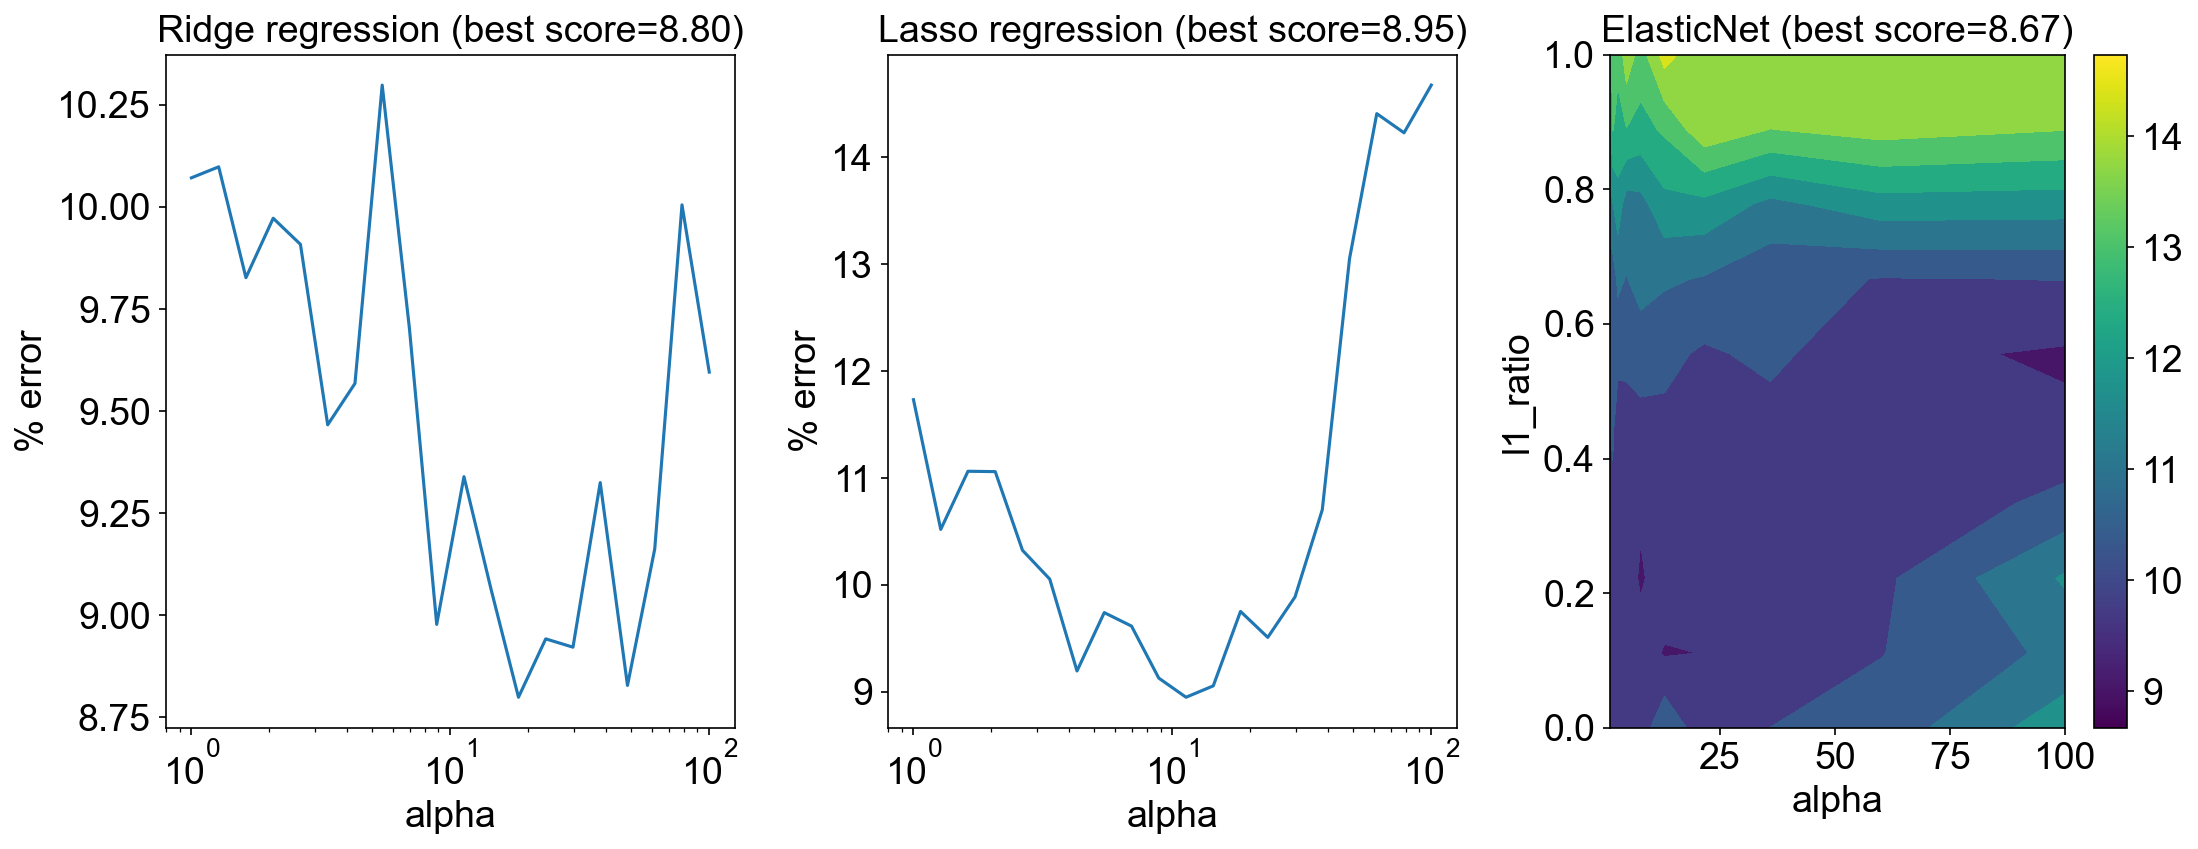

In [31]:
def plot_gridsearch(gridsearch):
    fig, axes = plt.subplots(1,3,figsize=(15,6))

    ax = axes[0]
    ax.semilogx(*gridsearch["Ridge"])
    ax.set_xlabel("alpha")
    ax.set_ylabel("% error")
    ax.set_title(f"Ridge regression (best score={np.min(gridsearch['Ridge'][1]):.2f})")

    ax = axes[1]
    ax.semilogx(*gridsearch["Lasso"])
    ax.set_xlabel("alpha")
    ax.set_ylabel("% error")
    ax.set_title(f"Lasso regression (best score={np.min(gridsearch['Lasso'][1]):.2f})")

    ax = axes[2]
    ax.contourf(*gridsearch["ElasticNet"])
    ax.set_title(f"ElasticNet (best score={np.min(gridsearch['ElasticNet'][2]):.2f})")
    ax.set_xlabel("alpha")
    ax.set_ylabel("l1_ratio")
    vmin = np.min(gridsearch['ElasticNet'][2])
    vmax = np.max(gridsearch['ElasticNet'][2])
    plt.colorbar(cm.ScalarMappable(colors.Normalize(vmin=vmin, vmax=vmax)), ax=ax)

    fig.tight_layout()
    return fig

fig = plot_gridsearch(gridsearch)
fig.savefig(OUTPUT_DIR + "manual_gridsearch.pdf")

### Manual, high corr features

In [32]:
gridsearch_highcorr = manual_gridsearch(high_corr_form_features, yvar70)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.19613806473717, tolerance: 7.6430933333333355
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.073455176869174, tolerance: 5.990773333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.440178317510799, tolerance: 5.73264
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

0


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14878.20065865269, tolerance: 7.167293333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12518.886685357304, tolerance: 6.337973333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9120.164522305064, tolerance: 4.716693333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9490.806830383252, tolerance: 5.90864
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14641.988187562838, tolerance: 6.804933333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9325.888195537626, tolerance: 5.245893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13050.699434475771, tolerance: 7.5532933333333325
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.916257200181462, tolerance: 6.055733333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.886217486108762, tolerance: 5.424
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12862.606213030775, tolerance: 6.871733333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14692.864986184468, tolerance: 7.346893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16391.016986261566, tolerance: 7.319893333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14796.10058209066, tolerance: 7.6065733333333325
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15819.243605082847, tolerance: 6.877733333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14999.647632372511, tolerance: 7.729493333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14064.43070512415, tolerance: 6.928160000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13883.426597323896, tolerance: 7.578773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15448.917519233884, tolerance: 6.688373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10912.817602701376, tolerance: 5.333360000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18849.057749502615, tolerance: 7.532640000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17405.73272424848, tolerance: 6.840960000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17928.586066823354, tolerance: 7.445240000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17242.95007007051, tolerance: 7.86504
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17090.441799438184, tolerance: 6.518173333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16736.13235162323, tolerance: 7.975093333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17092.261860215982, tolerance: 7.5396
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15461.085176418366, tolerance: 6.459893333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17535.315573924632, tolerance: 7.898293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17481.66103773513, tolerance: 7.946773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17699.6511193403, tolerance: 7.577333333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17389.053961082824, tolerance: 7.8794400000000016
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13252.087467090123, tolerance: 5.664960000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18639.679843370104, tolerance: 7.4969600000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objectiv

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.046699660342711, tolerance: 5.6659733333333335
  model = cd_fast.enet_coordinate_descent(


4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20038.715392512288, tolerance: 6.8604
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15562.071941428021, tolerance: 5.851893333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13400.811345606518, tolerance: 5.112240000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15812.041602101848, tolerance: 5.889173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21705.90966079194, tolerance: 7.181093333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20250.794200148244, tolerance: 6.928773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20236.255272500686, tolerance: 6.845360000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19580.83743558937, tolerance: 6.441133333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21289.411695728424, tolerance: 6.911093333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

5


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23611.794825100336, tolerance: 6.880693333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25253.02313896074, tolerance: 7.813173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17311.014479597252, tolerance: 5.8742399999999995
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16422.730256413466, tolerance: 5.136960000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23211.672197950116, tolerance: 7.3751733333333345
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25209.087300419713, tolerance: 7.413493333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25364.65328202914, tolerance: 7.792373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26121.299311632494, tolerance: 8.193973333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23555.52250357231, tolerance: 6.723173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

6


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25276.67941833513, tolerance: 6.5118
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29058.088377707034, tolerance: 8.097933333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26392.520844806575, tolerance: 6.9263733333333315
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27892.93261371646, tolerance: 7.619893333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28372.948107645887, tolerance: 7.907893333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23805.70831186584, tolerance: 6.23604
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29584.248039658825, tolerance: 7.928133333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18999.07161289141, tolerance: 5.300400000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27643.681207151716, tolerance: 7.59216
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

7


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27560.207300497, tolerance: 6.68136
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32483.730317674992, tolerance: 8.341893333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28476.70239033206, tolerance: 7.117440000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conver

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23938.13867511062, tolerance: 5.595093333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20310.719170134304, tolerance: 5.081759999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27261.007269272992, tolerance: 6.529893333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25239.913167341165, tolerance: 5.948573333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22073.55126824381, tolerance: 5.528640000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27902.385037763877, tolerance: 6.918893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

8


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31843.859480802796, tolerance: 7.2444933333333354
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18459.851592593506, tolerance: 4.26084
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22021.187301469796, tolerance: 5.283893333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not c

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28884.644818378027, tolerance: 6.675959999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31207.45717114772, tolerance: 7.051200000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31866.02913583903, tolerance: 7.2325333333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29478.290017463343, tolerance: 6.6516
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32517.90263735876, tolerance: 7.441973333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31001.056523313702, tolerance: 7.057573333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

9


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34008.231287129005, tolerance: 7.428559999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32684.918679094004, tolerance: 7.078533333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34437.98455852418, tolerance: 7.555573333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30778.985665224398, tolerance: 6.726360000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33245.91516712086, tolerance: 7.25464
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31031.377085055898, tolerance: 6.734493333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27403.18716212551, tolerance: 5.876573333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23021.63870618716, tolerance: 5.045093333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34348.273254531916, tolerance: 7.463760000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

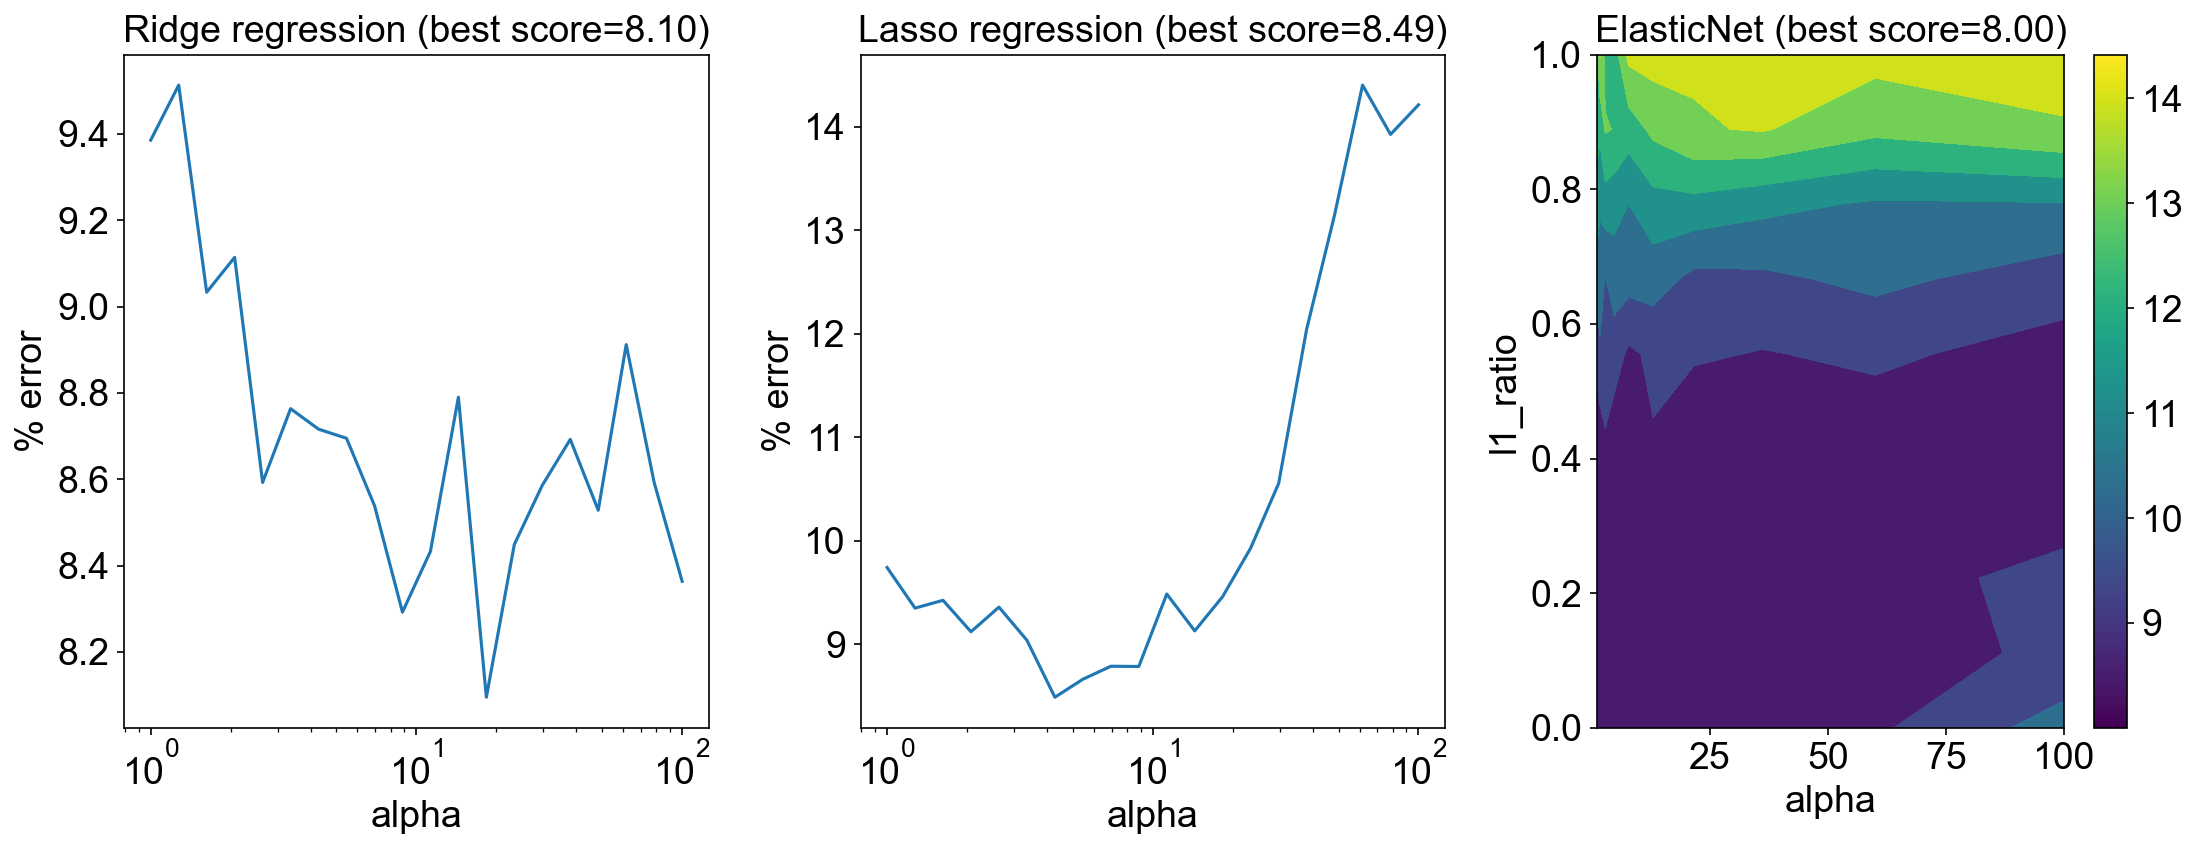

In [33]:
fig = plot_gridsearch(gridsearch_highcorr)
fig.savefig(OUTPUT_DIR + "manual_gridsearch_highcorr.pdf")

0


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15967.85211610431, tolerance: 4.855693333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23702.15667389461, tolerance: 6.9181333333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24453.744358675875, tolerance: 7.377893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23332.795774140406, tolerance: 6.7825733333333345
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23574.479044763568, tolerance: 7.5443733333333345
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25243.831650835375, tolerance: 7.6158399999999995
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objecti

1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30055.274564109044, tolerance: 8.012933333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27315.51618191633, tolerance: 7.6584
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26530.674289221795, tolerance: 6.9758400000000025
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27363.99825555089, tolerance: 7.147533333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27302.159109524724, tolerance: 7.1651733333333345
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28161.55180407626, tolerance: 7.7088
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22182.29556986183, tolerance: 5.426240000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30069.292627475406, tolerance: 7.42944
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27657.227178946283, tolerance: 6.636293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26795.124623977867, tolerance: 6.362693333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27154.04176629345, tolerance: 6.675960000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31821.863891010093, tolerance: 7.706293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21779.615750817356, tolerance: 4.978773333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34903.43841719971, tolerance: 8.1114
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34502.91879497451, tolerance: 7.8886933333333324
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21208.76303513738, tolerance: 4.802173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30969.982759164854, tolerance: 6.988733333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36193.39646374127, tolerance: 8.44124
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32426.476850487288, tolerance: 6.973173333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29864.650512080912, tolerance: 6.4864933333333346
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34967.56416277885, tolerance: 7.622960000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35120.343608549396, tolerance: 7.694293333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34751.170988442136, tolerance: 7.503173333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34018.26664427003, tolerance: 7.382933333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

5


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36402.4664527194, tolerance: 7.662373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32917.948258819764, tolerance: 6.956373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21557.433198766947, tolerance: 4.542093333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32548.099725069875, tolerance: 6.821573333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33465.736839884215, tolerance: 6.997093333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38518.913138162374, tolerance: 8.150293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

6


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24913.1436734617, tolerance: 5.149733333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33690.26150961205, tolerance: 6.9501333333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38304.90309070173, tolerance: 7.916173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34948.34510629434, tolerance: 7.194293333333335
  model = cd_fast.enet_coordinate_descent(


7


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39418.8298414152, tolerance: 8.054293333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36781.34534891094, tolerance: 7.487333333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33860.54004416525, tolerance: 6.884693333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39106.288978345656, tolerance: 7.98204
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34065.77218796743, tolerance: 6.9298
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37274.857967250726, tolerance: 7.590093333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You 

8


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26518.079882485763, tolerance: 5.364733333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36555.95988821992, tolerance: 7.387893333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34026.22270350438, tolerance: 6.875133333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31279.228606394405, tolerance: 6.319933333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37021.401592683986, tolerance: 7.487493333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36661.714370202346, tolerance: 7.420373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

9


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34736.03058630259, tolerance: 6.989360000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37390.28117055005, tolerance: 7.5266
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41181.66663392253, tolerance: 8.299573333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conver

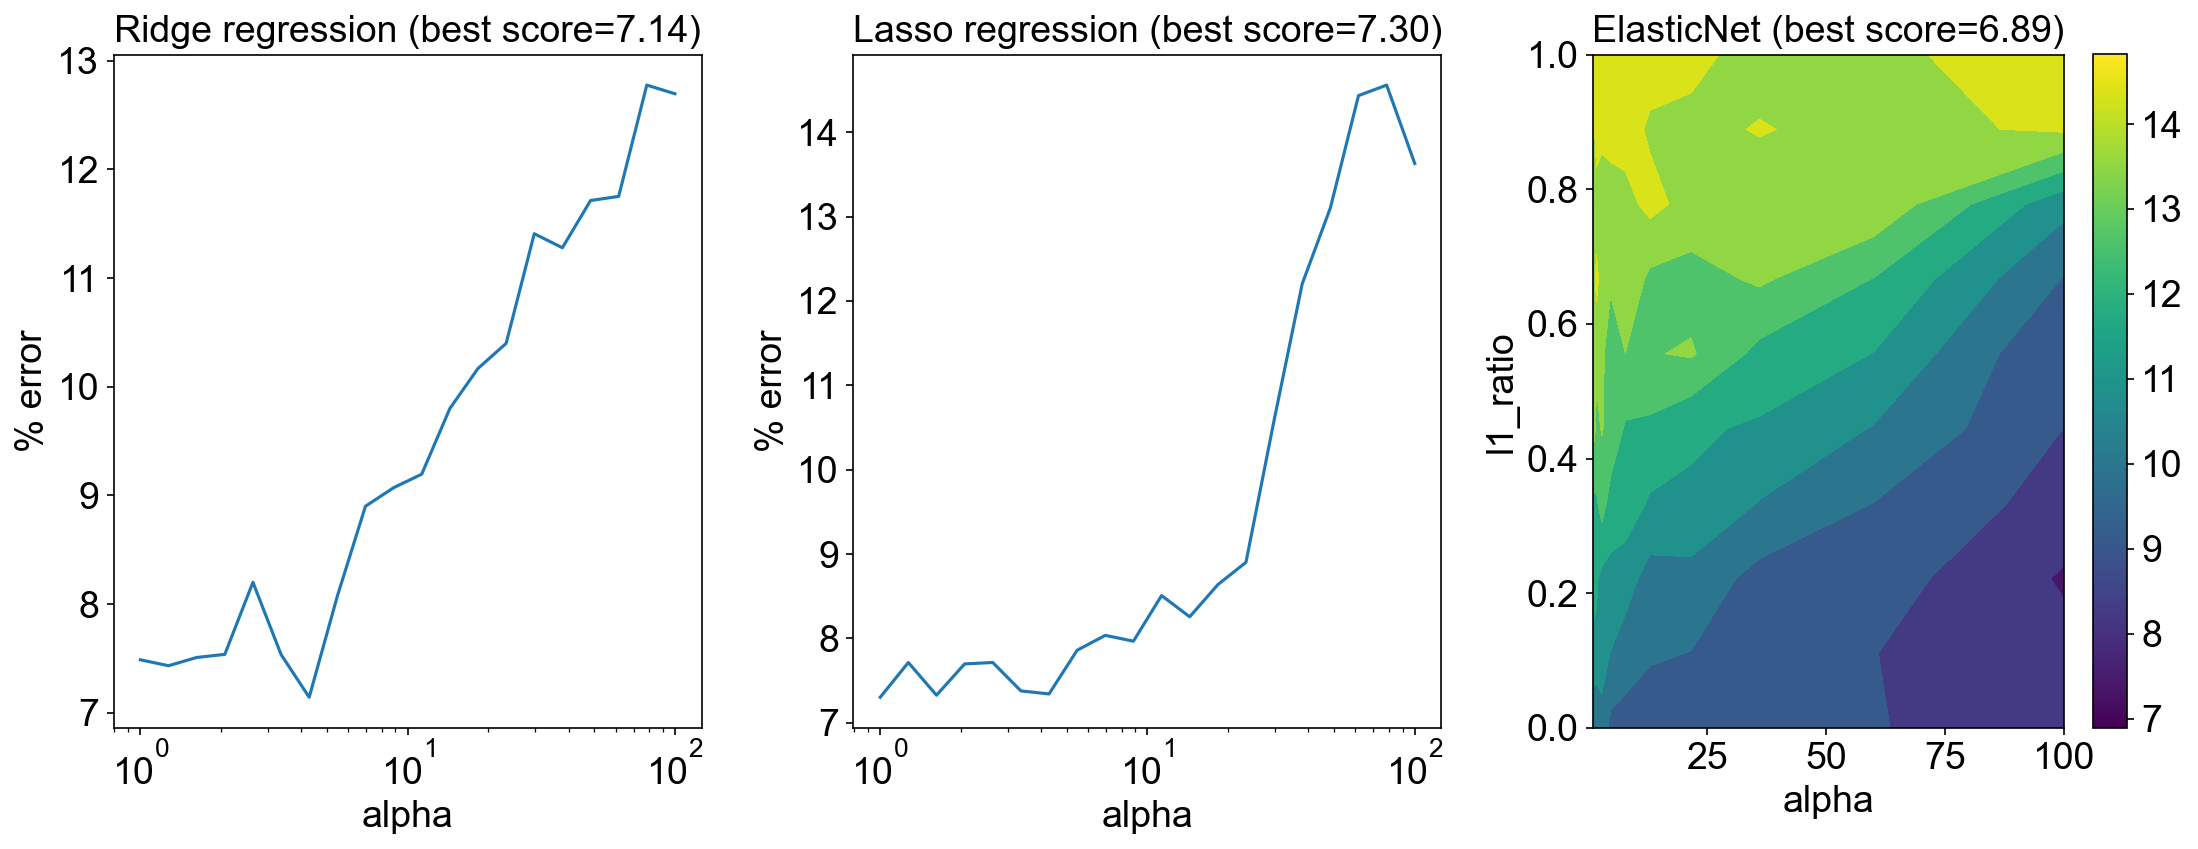

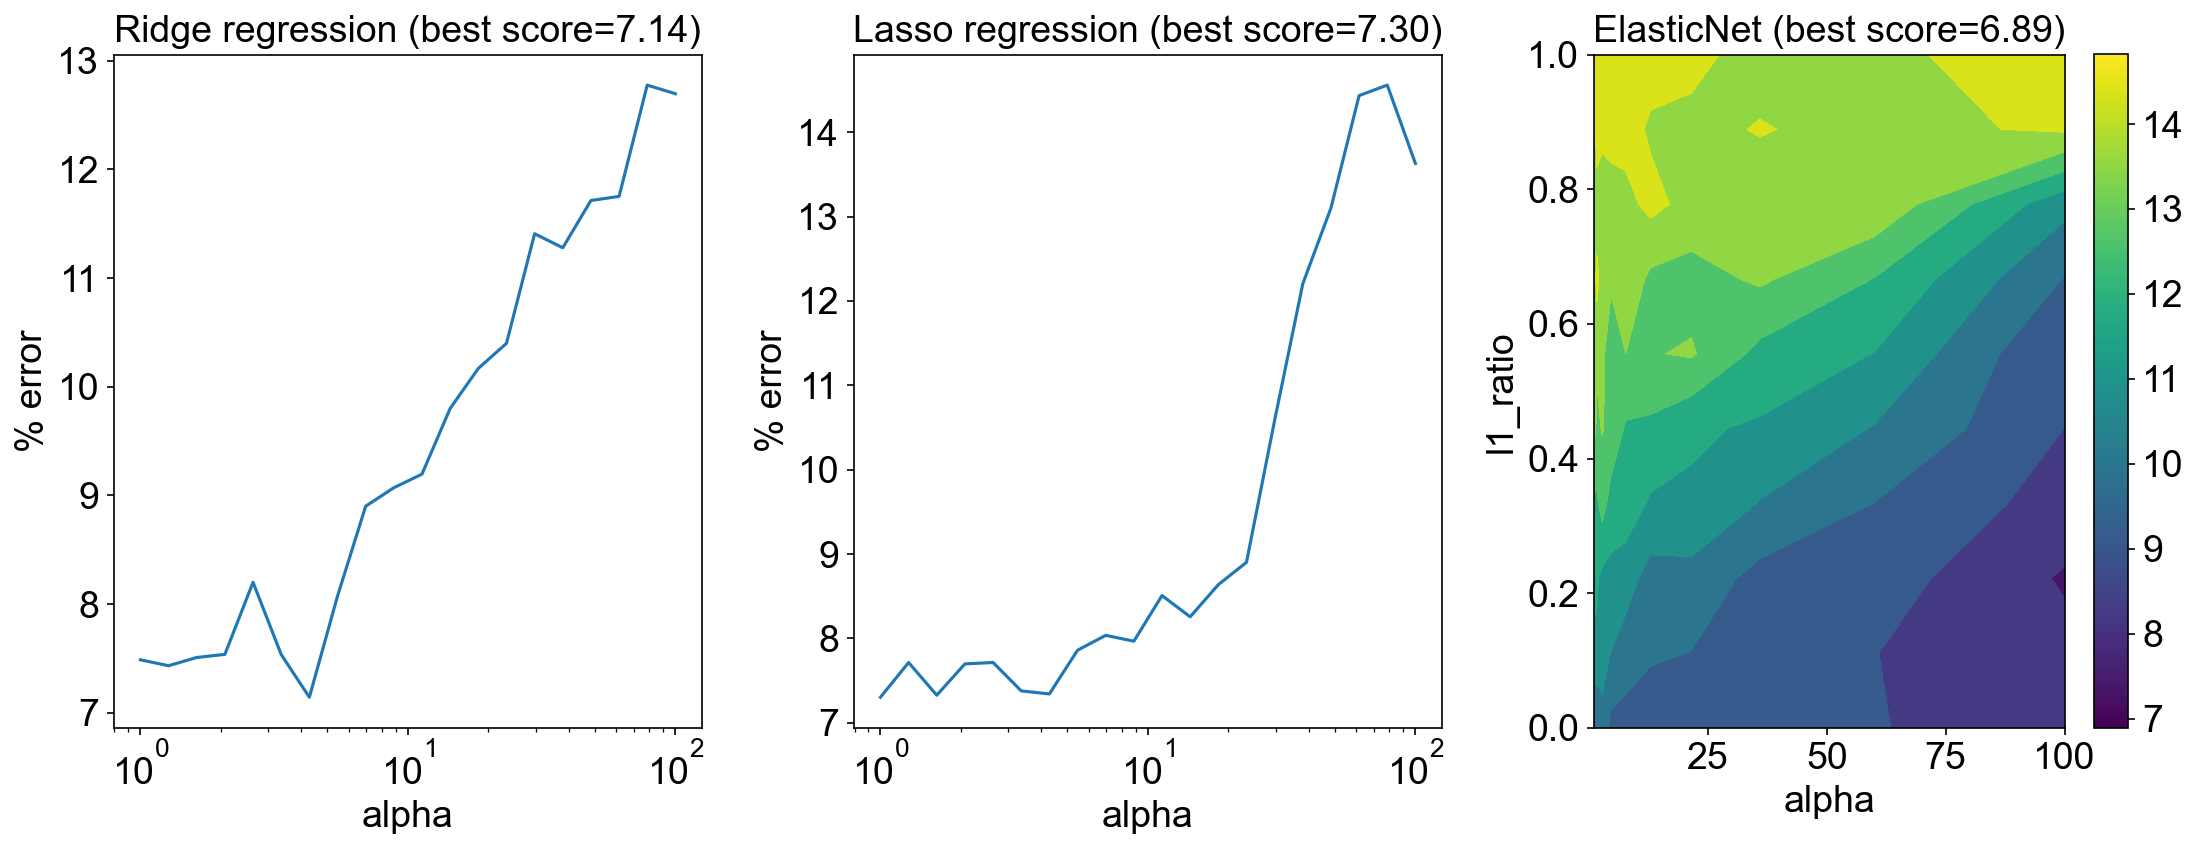

In [34]:
plot_gridsearch(manual_gridsearch("form_first_discharge_capacity_ah", yvar70))

### Manual, very high corr

In [35]:
gridsearch_veryhighcorr = manual_gridsearch(very_high_corr_form_features, yvar70)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.764323849660286, tolerance: 5.418493333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.41405660233977, tolerance: 5.476093333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.727946418832289, tolerance: 5.341173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.897907742200914, tolerance: 5.660933333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.70979699802956, tolerance: 5.204159999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.2448409694970906, tolerance: 4.963893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

0


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10815.52817558953, tolerance: 5.6849733333333345
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13972.406473728719, tolerance: 6.8287733333333325
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15580.477357863594, tolerance: 6.985240000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15133.226545030764, tolerance: 7.681333333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13733.957638670772, tolerance: 7.69896
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14949.626634001694, tolerance: 7.390639999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not co

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.76991779905984, tolerance: 5.045093333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.955667423248087, tolerance: 6.127573333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.261152023733302, tolerance: 6.005093333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16879.012584449, tolerance: 7.373733333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17420.59532425568, tolerance: 7.742533333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11632.481944680074, tolerance: 5.818293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16492.157455468892, tolerance: 6.743773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18260.796886390464, tolerance: 7.360493333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17533.184708443452, tolerance: 6.742373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.169281952705205, tolerance: 4.40076
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.13063690130366, tolerance: 5.15264
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.774491382890119, tolerance: 5.851893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You mi

2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20792.681877704246, tolerance: 7.679039999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19962.6366340115, tolerance: 7.343173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19964.922803026708, tolerance: 7.033693333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20085.11536844556, tolerance: 7.662373333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12918.46096612387, tolerance: 5.062773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21597.530587696434, tolerance: 8.268933333333331
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.099541415856947, tolerance: 4.5654
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.745986318986979, tolerance: 5.726773333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.607779308713361, tolerance: 5.411693333333333
  model = cd_fast.enet_coordinate_descent(


3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15778.520448453777, tolerance: 5.245893333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21439.382943670596, tolerance: 6.490133333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17296.625589708965, tolerance: 5.816933333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22418.704498388193, tolerance: 7.1251733333333345
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23866.603363388298, tolerance: 7.623973333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21647.298555603877, tolerance: 6.511773333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.969706062263867, tolerance: 5.343839999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.050556383113872, tolerance: 5.597293333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.939837987134524, tolerance: 5.43036
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conve

4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25733.228642060203, tolerance: 7.7126
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23462.28798758294, tolerance: 6.408373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17814.595470440945, tolerance: 5.192133333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24011.282577972455, tolerance: 6.747373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24261.171429709946, tolerance: 6.65524
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24345.180961770235, tolerance: 6.792400000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not co

5


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28447.30616810502, tolerance: 7.426693333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31500.92744610179, tolerance: 8.41764
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29237.677854275385, tolerance: 7.443173333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29675.33731408353, tolerance: 7.87944
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29329.272400992893, tolerance: 7.464373333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27981.12754100966, tolerance: 6.9777733333333325
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

6


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28916.41176897785, tolerance: 6.716173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27255.962993046116, tolerance: 6.350173333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30306.295357290845, tolerance: 7.11504
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30833.10710347766, tolerance: 7.194773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33199.18538037764, tolerance: 7.913373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33149.196748214796, tolerance: 7.992960000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

7


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33755.40533631735, tolerance: 7.557493333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35280.96805632148, tolerance: 7.942293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24726.501406299085, tolerance: 5.466933333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30091.06533668394, tolerance: 6.605773333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33789.634456622465, tolerance: 7.441973333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32398.969171086068, tolerance: 7.253333333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33467.57097144151, tolerance: 7.407573333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29466.69645173832, tolerance: 6.456640000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30541.094147414828, tolerance: 6.710093333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

8


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32433.12214560334, tolerance: 6.927973333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35359.01784613806, tolerance: 7.54904
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27217.15087615744, tolerance: 5.805893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conve

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34269.64363046959, tolerance: 7.350133333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35129.50378641026, tolerance: 7.469093333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24973.848659892166, tolerance: 5.308133333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36919.56128941351, tolerance: 7.849093333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33426.1582234106, tolerance: 7.079573333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33706.094657040325, tolerance: 7.172093333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

9


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28020.962000511172, tolerance: 5.839573333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25460.273362121643, tolerance: 5.2599333333333345
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36505.32872432367, tolerance: 7.590973333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30585.768780520422, tolerance: 6.350173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35635.22230460084, tolerance: 7.391573333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40070.53042519379, tolerance: 8.361093333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

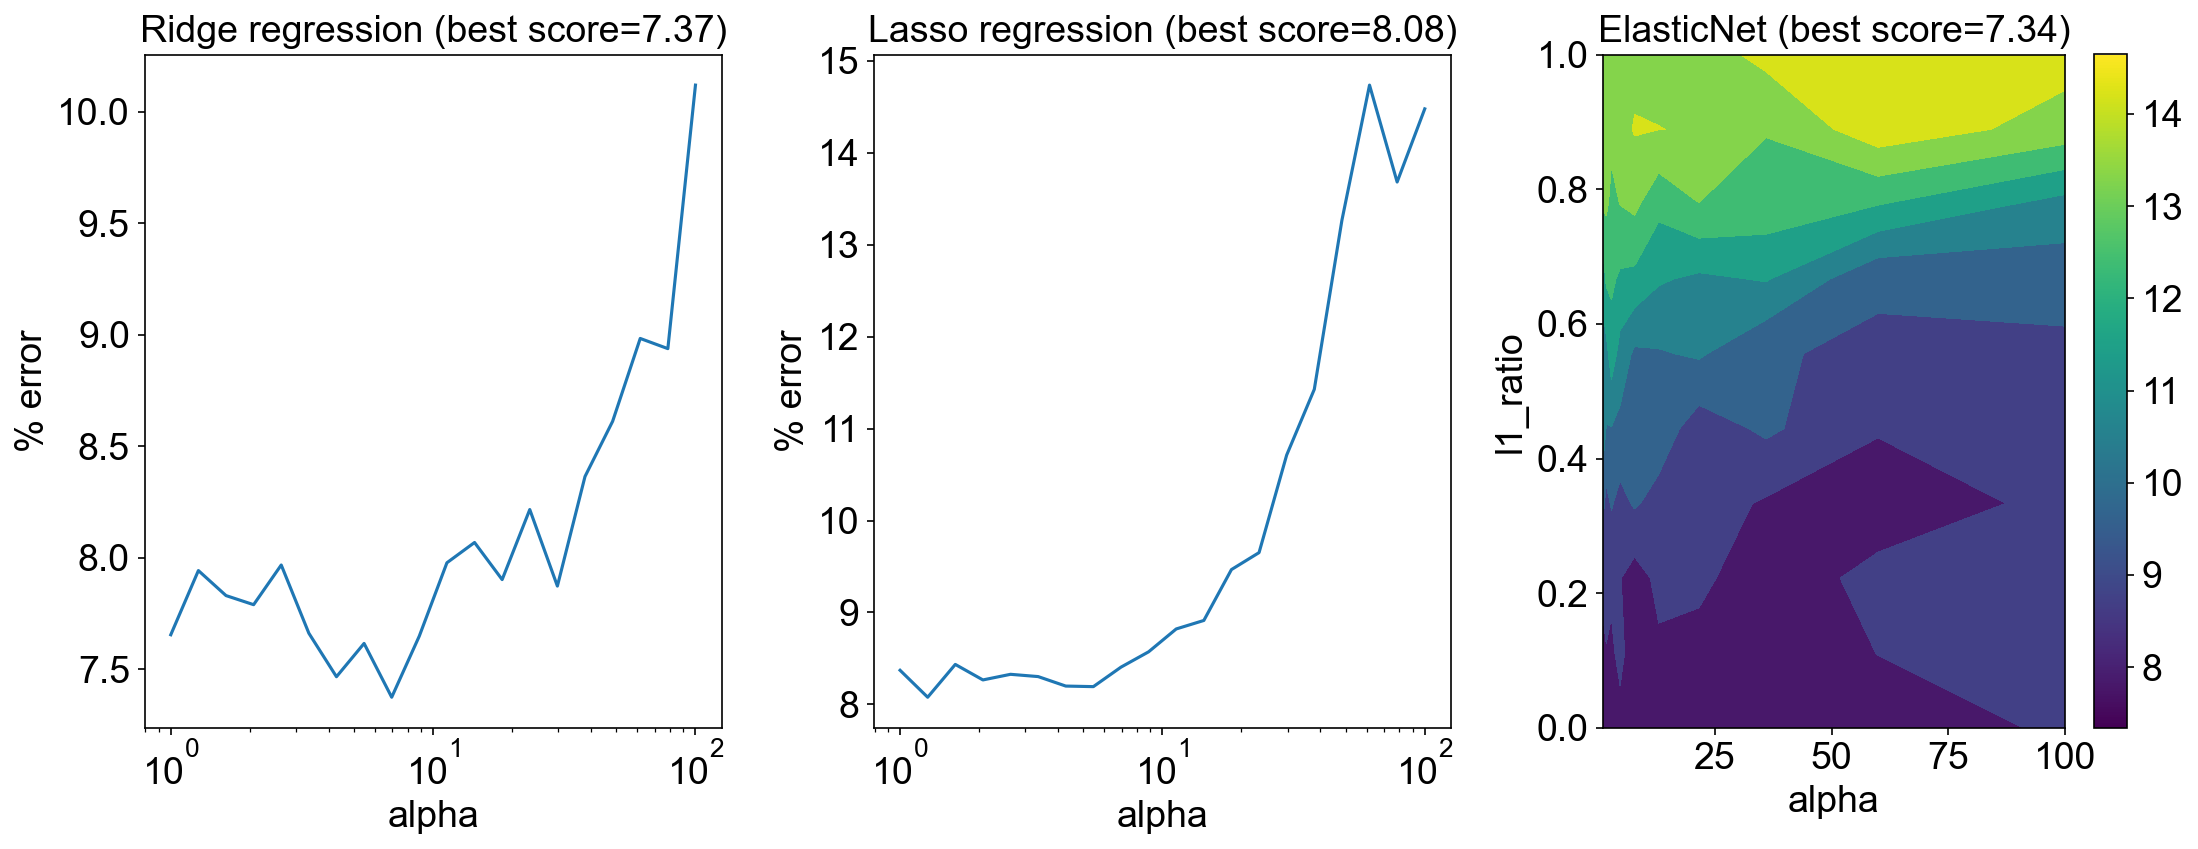

In [36]:
fig = plot_gridsearch(gridsearch_veryhighcorr)
fig.savefig(OUTPUT_DIR + "manual_gridsearch_veryhighcorr.pdf")

In [37]:
yvar

'cycles_to_70_pct'

## Printing lots of models

In [38]:
def print_model(model, yvar, **kwargs):
    print(model)
    print("Label: ", yvar)
    for f in very_high_corr_form_features:
        out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000,
                                  **kwargs)
        print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
    out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000,
                              **kwargs)
    print(f"{'Dummy regressor (predict mean)':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, very_high_corr_form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'very high corr':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, high_corr_form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'high corr':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'all':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    # out = train_and_test_model(df, very_high_corr_form_features, yvar, to_plot=0, model=Lasso(5), num_experiments=1000)
    # print(f"{'Lasso(5), very high corr':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    

In [39]:
print_model(ElasticNet(alpha=50, l1_ratio=0.3), yvar70)

ElasticNet(alpha=50, l1_ratio=0.3)
Label:  cycles_to_70_pct
form_first_discharge_capacity_below_3p2v_ah       7.77 (2.55 std)
form_last_charge_voltage_after_1s                 7.56 (2.50 std)
form_last_charge_voltage_after_60s                7.72 (2.55 std)
form_first_discharge_capacity_ah                  7.59 (2.48 std)
form_first_cycle_efficiency                       7.37 (2.45 std)
form_c20_charge_right_peak_v_per_ah               8.48 (2.62 std)
Dummy regressor (predict mean)          14.68 (4.10 std)
very high corr                          13.31 (3.93 std)
high corr                               12.21 (3.78 std)
all                                     11.93 (3.62 std)


In [40]:
print_model(Ridge(10), yvar50)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.27 (2.47 std)
form_last_charge_voltage_after_1s                 7.09 (2.36 std)
form_last_charge_voltage_after_60s                7.05 (2.31 std)
form_first_discharge_capacity_ah                  7.25 (2.45 std)
form_first_cycle_efficiency                       7.18 (2.35 std)
form_c20_charge_right_peak_v_per_ah               8.17 (2.17 std)
Dummy regressor (predict mean)          12.81 (3.17 std)
very high corr                          7.33 (2.23 std)
high corr                               7.73 (2.47 std)
all                                     9.04 (2.66 std)


In [41]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, log=False)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.31 (2.51 std)
form_last_charge_voltage_after_1s                 7.21 (2.41 std)
form_last_charge_voltage_after_60s                7.05 (2.32 std)
form_first_discharge_capacity_ah                  6.98 (2.34 std)
form_first_cycle_efficiency                       7.03 (2.32 std)
form_c20_charge_right_peak_v_per_ah               8.12 (2.24 std)
Dummy regressor (predict mean)          12.68 (3.15 std)
very high corr                          7.40 (2.27 std)
high corr                               7.60 (2.42 std)
all                                     9.04 (2.67 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.60 (2.66 std)
form_last_charge_voltage_after_1s                 7.33 (2.52 std)
form_last_charge_voltage_after_60s                7.51 (2.63 std)
form_first_discharge_capacity_ah                  7.23 (2.54 std)
form_first_cycle_efficiency      

In [42]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, log=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.08 (2.49 std)
form_last_charge_voltage_after_1s                 7.18 (2.44 std)
form_last_charge_voltage_after_60s                6.90 (2.34 std)
form_first_discharge_capacity_ah                  7.13 (2.35 std)
form_first_cycle_efficiency                       7.12 (2.40 std)
form_c20_charge_right_peak_v_per_ah               7.92 (2.19 std)
Dummy regressor (predict mean)          12.64 (3.08 std)
very high corr                          7.08 (2.23 std)
high corr                               7.47 (2.47 std)
all                                     8.62 (2.59 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.39 (2.46 std)
form_last_charge_voltage_after_1s                 7.31 (2.60 std)
form_last_charge_voltage_after_60s                7.24 (2.48 std)
form_first_discharge_capacity_ah                  7.22 (2.53 std)
form_first_cycle_efficiency      

In [43]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, square=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.47 (2.64 std)
form_last_charge_voltage_after_1s                 7.38 (2.35 std)
form_last_charge_voltage_after_60s                7.26 (2.24 std)
form_first_discharge_capacity_ah                  7.23 (2.43 std)
form_first_cycle_efficiency                       7.12 (2.43 std)
form_c20_charge_right_peak_v_per_ah               8.07 (2.33 std)
Dummy regressor (predict mean)          13.05 (3.21 std)
very high corr                          7.63 (2.34 std)
high corr                               7.82 (2.51 std)
all                                     9.71 (2.82 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.59 (2.72 std)
form_last_charge_voltage_after_1s                 7.60 (2.63 std)
form_last_charge_voltage_after_60s                7.67 (2.66 std)
form_first_discharge_capacity_ah                  7.36 (2.48 std)
form_first_cycle_efficiency      

In [44]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, sqrt=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.18 (2.50 std)
form_last_charge_voltage_after_1s                 7.06 (2.36 std)
form_last_charge_voltage_after_60s                7.06 (2.26 std)
form_first_discharge_capacity_ah                  7.00 (2.34 std)
form_first_cycle_efficiency                       7.03 (2.37 std)
form_c20_charge_right_peak_v_per_ah               8.12 (2.28 std)
Dummy regressor (predict mean)          12.88 (3.12 std)
very high corr                          7.39 (2.24 std)
high corr                               7.51 (2.41 std)
all                                     8.71 (2.52 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.49 (2.67 std)
form_last_charge_voltage_after_1s                 7.35 (2.50 std)
form_last_charge_voltage_after_60s                7.43 (2.58 std)
form_first_discharge_capacity_ah                  7.14 (2.55 std)
form_first_cycle_efficiency      

## PCA

In [45]:
df_form.corr()["form_first_discharge_capacity_ah"].sort_values()

form_last_charge_voltage_after_60s            -0.980428
form_6hr_rest_delta_voltage_v_0_to_3_hr       -0.916951
form_6hr_rest_delta_voltage_v_0_to_2_hr       -0.915978
form_6hr_rest_delta_voltage_v_0_to_4_hr       -0.913766
form_6hr_rest_delta_voltage_v_0_to_1_hr       -0.904858
form_6hr_rest_delta_voltage_v_0_to_5_hr       -0.903710
form_c20_charge_right_peak_v_per_ah           -0.898403
form_6hr_rest_delta_voltage_v_0_to_6_hr       -0.893952
form_6hr_rest_delta_voltage_v                 -0.890137
cycles_to_70_pct                              -0.822596
form_6hr_rest_delta_voltage_v_1_to_6_hr       -0.789071
cycles_to_80_pct                              -0.788770
cycles_to_60_pct                              -0.785245
cycles_to_50_pct                              -0.782680
form_6hr_rest_delta_voltage_v_2_to_6_hr       -0.692257
form_6hr_rest_delta_voltage_v_3_to_6_hr       -0.634634
form_6hr_rest_delta_voltage_v_4_to_6_hr       -0.598132
form_6hr_rest_delta_voltage_v_5_to_6_hr       -0

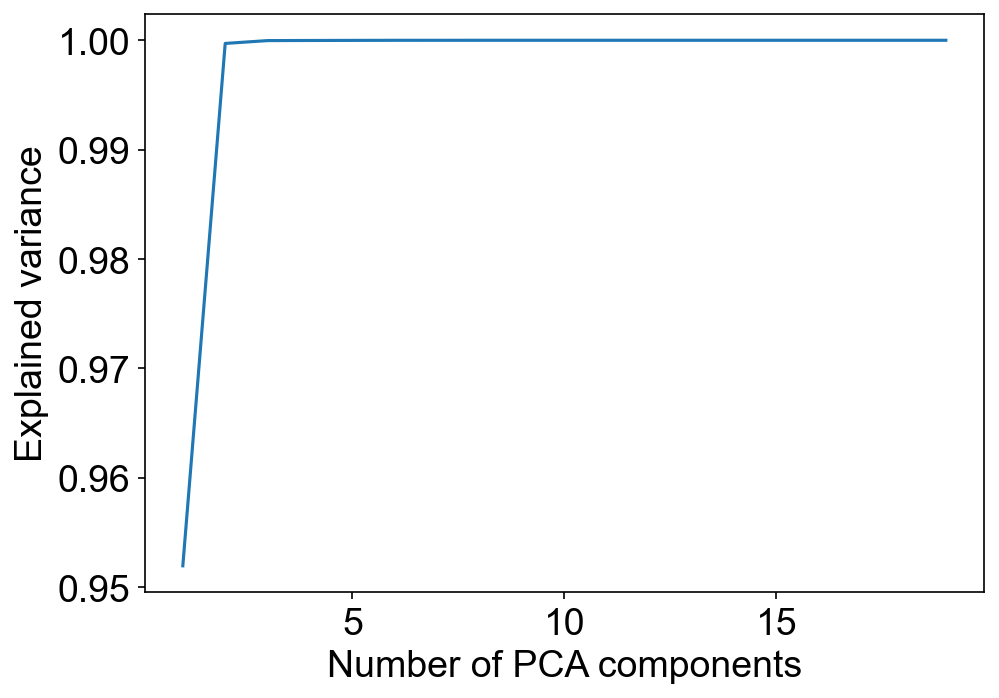

In [46]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_form[form_features])
cumsum = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots()
ax.plot(range(1,len(cumsum)+1),cumsum)
ax.set_xlabel("Number of PCA components")
ax.set_ylabel("Explained variance")
fig.savefig(OUTPUT_DIR + "pca.pdf")

In [47]:
log = False
to_plot = False
yvar = yvar70
model = LinearRegression()
xvars = very_high_corr_form_features
# xvars = ["form_first_discharge_capacity_ah"]

# Fraction of samples reserved for model testing
# e.g. 0.2 means 20% of samples reserved. In the 
# context of cross-validation, this would be 
# equivalent to a 5-fold cross-validation. The 
# cross-validation we end up doing is not exactly
# 5-fold cross-validation since we introduce random
# sampling and many many repeats
TEST_SIZE = 0.2

# Number of trials
num_experiments = 1000

# Unpack and filter data
# Create a temporary df to filter NaNs only from the columns we use
xyvars = xvars + [yvar]
df_nonans = df[xyvars].dropna()
if log is True:
    df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))

X = df_nonans[xvars].values
pca = PCA(n_components=0.95)
# print(X)
X = pca.fit_transform(X)
# print(X)
# print(pca.explained_variance_ratio_)
y = df_nonans[yvar].values

percent_error_list = []
r2_score_list = []
rmse_list = []
baseline_rmse_list = []
intercept_list = []
coef_list = []
corr_list = []

has_plotted = 0

for idx in range(num_experiments):

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE)

    # apply standard scaler (fit only on train, transform both train and test)
    # keep originals for pltos
    X_train_original = X_train
    X_test_original = X_test
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    (model, corr) = build_model(X_train, y_train, model)

    y_pred = model.predict(X_test)
    y_train_mean = np.mean(y_train)

    r2_score = model.score(X_test, y_test)

    if log is True:
        y_train = np.exp(y_train)
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
        y_train_mean = np.exp(y_train_mean)

    rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
    percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
    baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))

    rmse_list.append(rmse)
    percent_error_list.append(percent_error)
    r2_score_list.append(r2_score)
    baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
    corr_list.append(corr)

    # Give a visual into the cross-validation process
    if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
        has_plotted = 1

        x_fit = np.linspace(np.min(X), np.max(X), 100)
        x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
        y_fit = model.predict(x_fit_trans)
        if log is True:
            y_fit = np.exp(y_fit)
        plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
        plt.plot(X_train_original, y_train, 'o', color='k')
        plt.plot(X_test_original, y_test, 's', color='r')

        for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
            plt.plot([this_x, this_x], 
                     [this_y, this_ypred], 
                     label='', color=(0.3, 0.3, 0.3))

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Model', 'Train', 'Test'])
        plt.show()

# Package the output
final_model = model
# Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)

final_rmse = np.mean(rmse_list)
final_rmse_std = np.std(rmse_list)

final_baseline_rmse = np.mean(baseline_rmse_list)
final_baseline_rmse_std = np.std(baseline_rmse_list)

# Column mean and column std of a list of tuples
final_corr = tuple(map(np.mean, zip(*corr_list)))
final_corr_std = tuple(map(np.std, zip(*corr_list)))

final_percent_error = np.mean(percent_error_list)
final_percent_error_std = np.std(percent_error_list)

#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
final_r2_score = np.mean(r2_score_list)
final_r2_score_std = np.std(r2_score_list)

model_output_dict = dict()
model_output_dict['model'] = final_model
model_output_dict['rmse'] = final_rmse
model_output_dict['rmse_std'] = final_rmse_std
model_output_dict['baseline_rmse'] = final_baseline_rmse
model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
model_output_dict['corr'] = final_corr
model_output_dict['corr_std'] = final_corr_std
model_output_dict['percent_error'] = final_percent_error
model_output_dict['percent_error_std'] = final_percent_error_std
model_output_dict['r2_score'] = final_r2_score
model_output_dict['r2_score_std'] = final_r2_score_std
model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
model_output_dict['features'] = tuple(xvars)

model_output_dict["percent_error"]

7.393294604338723

## Understanding the model

See https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html 

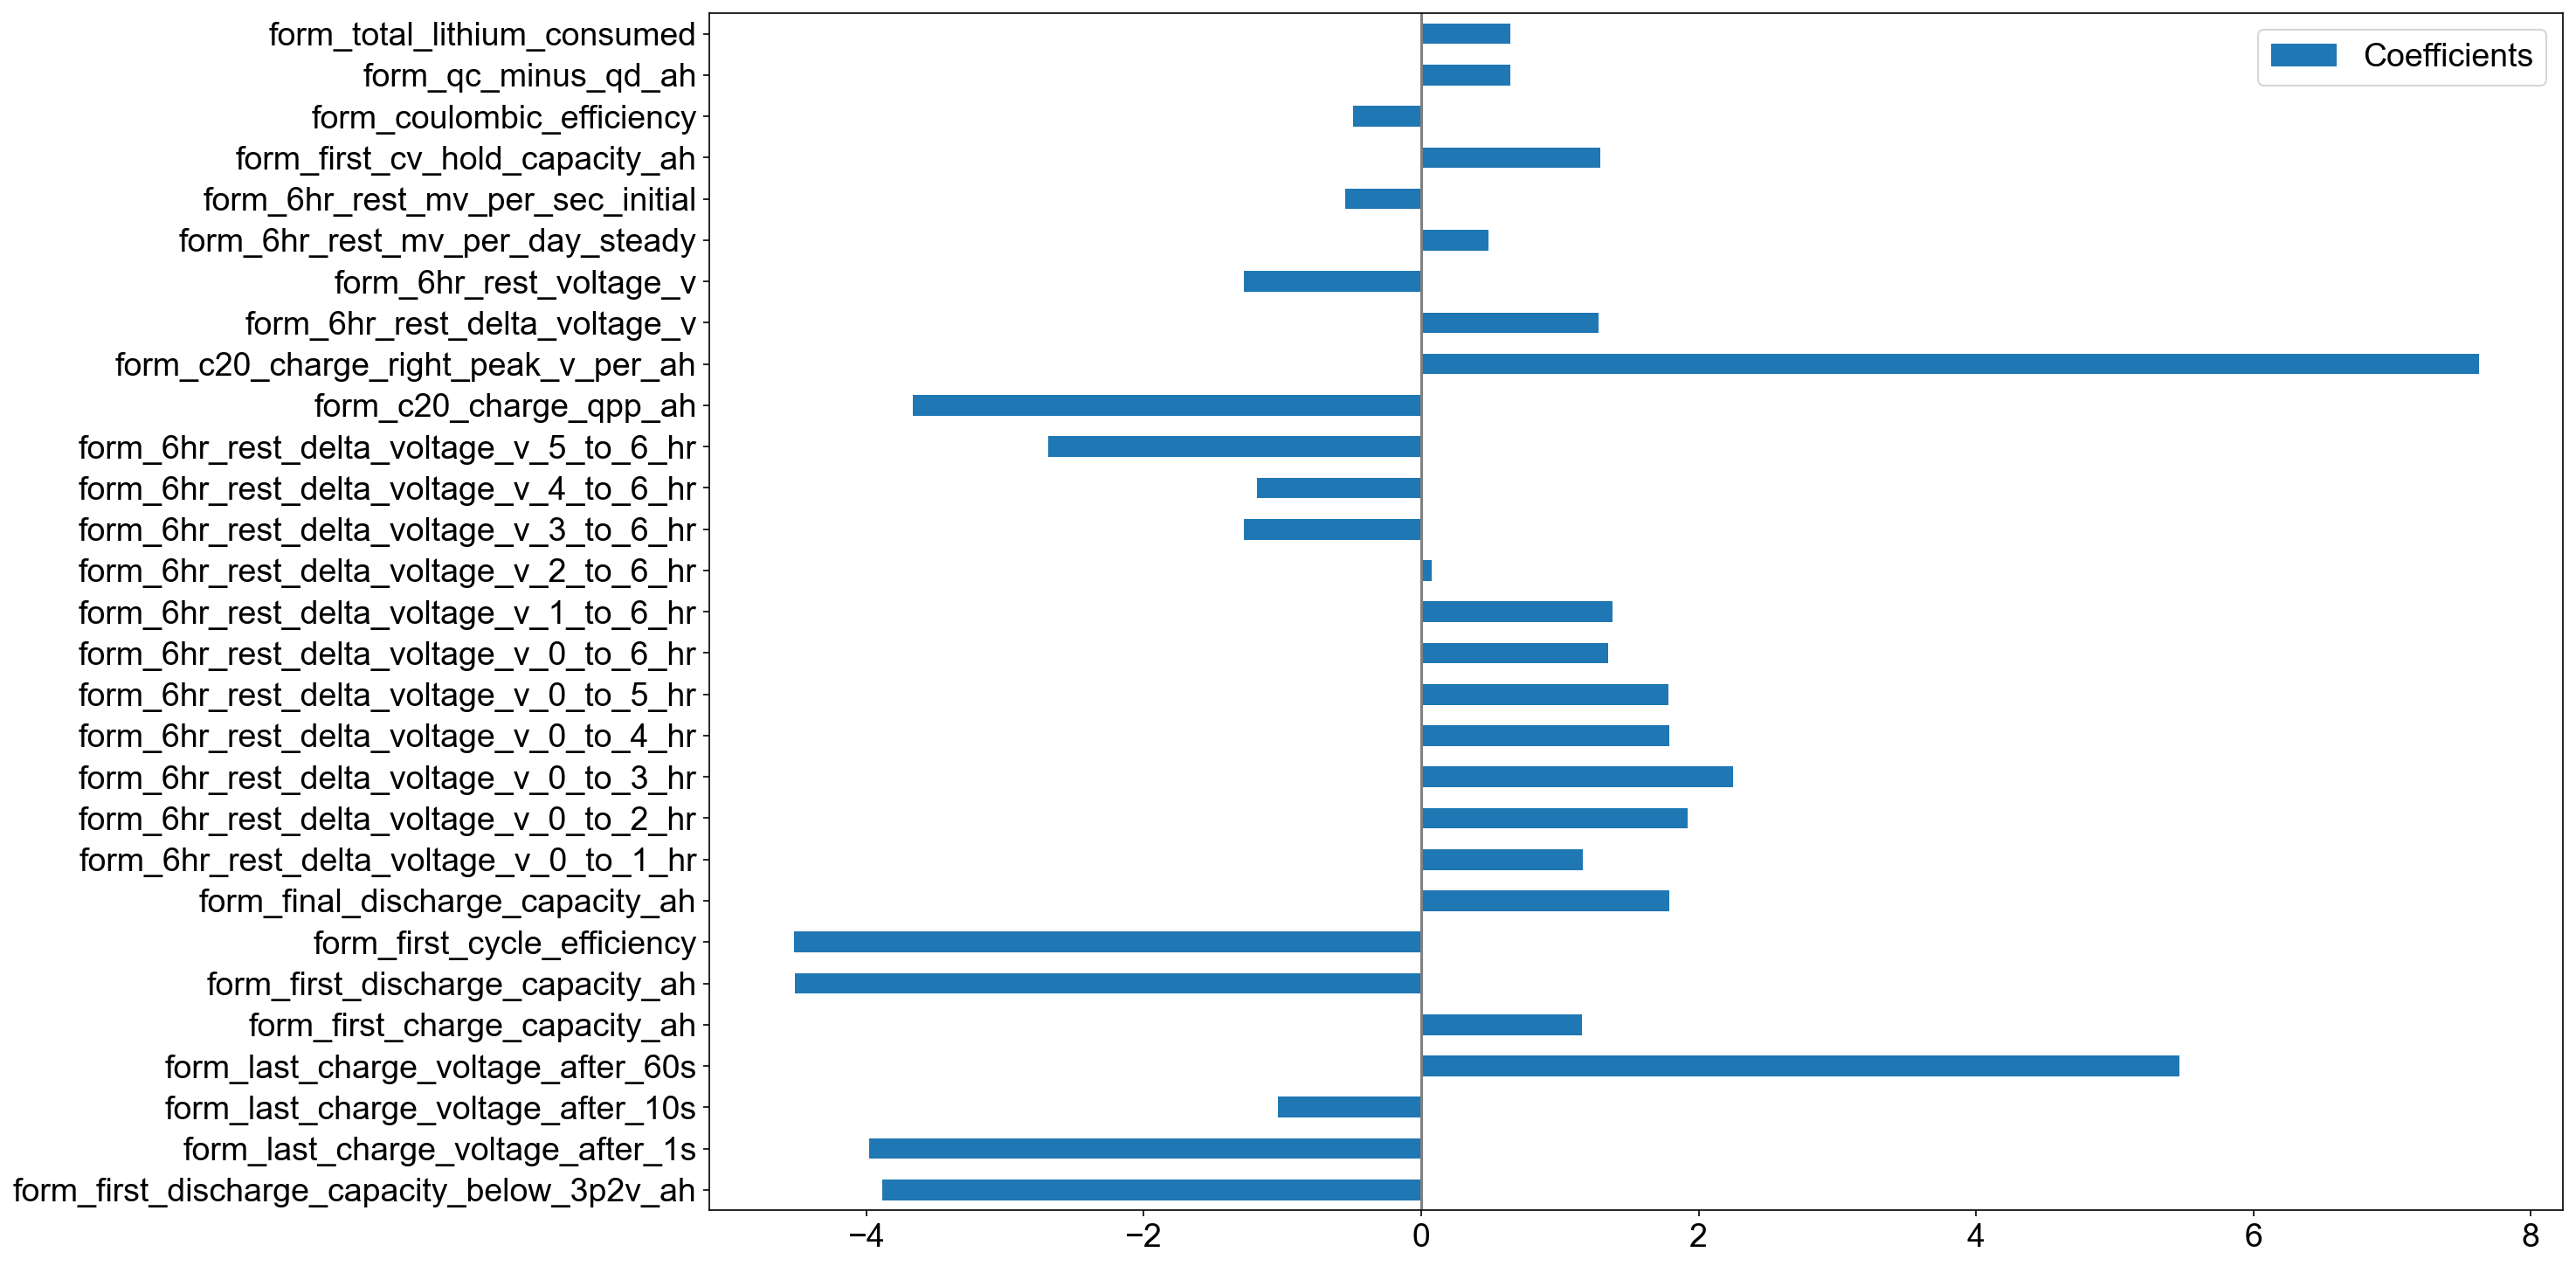

In [48]:
ridge = gridsearch["Ridge"]
alpha_ridge = ridge[0][np.argmin(ridge[1])]
model = Ridge(alpha_ridge)
out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
coefs = pd.DataFrame(
    model.coef_,
    columns=['Coefficients'], index=out["features"]
)
coefs.plot(kind="barh",figsize=(20,10))
plt.axvline(x=0, color='.5')

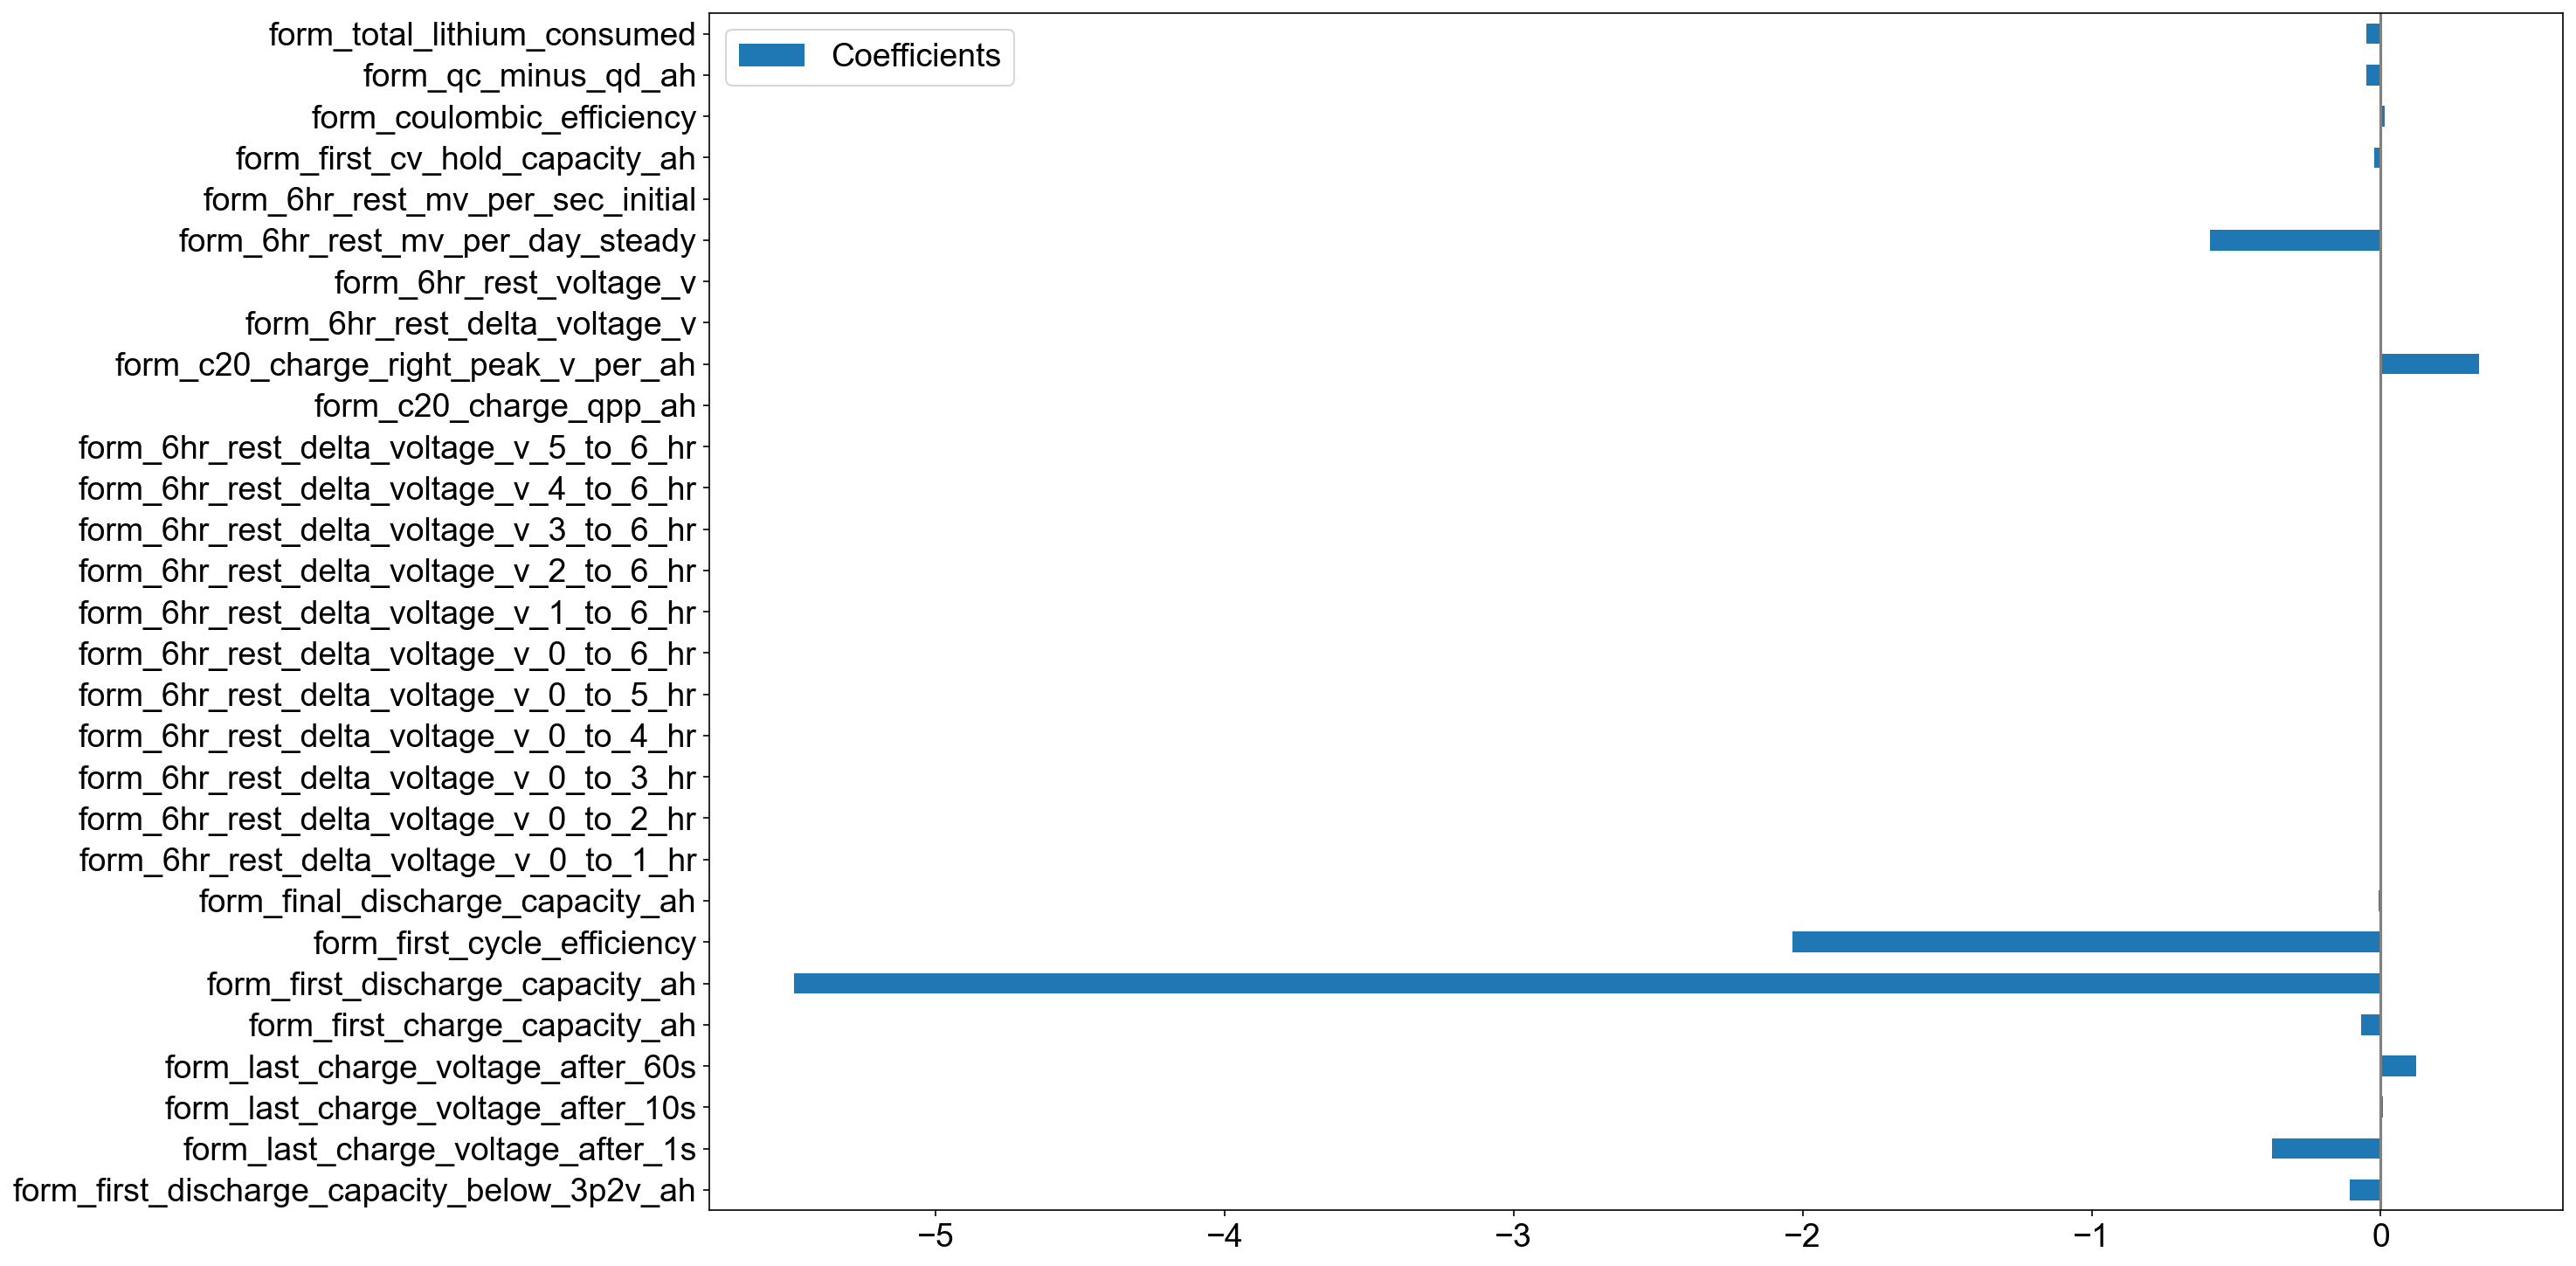

In [49]:
ridge = gridsearch["Ridge"]
alpha_ridge = ridge[0][np.argmin(ridge[1])]
model = Ridge(10)
out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
coefs = pd.DataFrame(
    model.coef_ * df[form_features].std(axis=0),
    columns=['Coefficients'], index=out["features"]
)
coefs.plot(kind="barh",figsize=(20,10))
plt.axvline(x=0, color='.5')
plt.savefig(OUTPUT_DIR + "model_coeffs.png")


In [50]:
feat = ["form_first_discharge_capacity_ah", "form_first_cycle_efficiency"]#, "form_6hr_rest_mv_per_day_steady"]
out = train_and_test_model(df, feat, yvar70, to_plot=0, model=Ridge(10), num_experiments=1000, log=True)
print(f"{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

7.77 (2.46 std)


In [51]:
out = train_and_test_model(df, ["form_first_discharge_capacity_ah", "form_first_cycle_efficiency", "form_6hr_rest_mv_per_day_steady"],
                                yvar70, to_plot=0, model=ElasticNet(alpha=0.01,l1_ratio=0.3), num_experiments=1000,
                                  log=True)
print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

form_total_lithium_consumed                       7.82 (2.89 std)


# Including features up to cycle 3

In [52]:
c3_select = lambda x: ((x.endswith("_c3") or x.startswith("esoh_c3_") or x.startswith("rpt_c3_"))
                       and not any(s in x for s in ["LLI", "LAM", "Qcomp", "C20_loss"]))
c3_features = list(filter(c3_select, df.columns))
label_select = lambda x: x.startswith("cycles_to_")
labels = list(filter(label_select, df.columns))
df_c3 = df[c3_features + labels]
df_c3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   retention_at_c3        19 non-null     float64
 1   dcr_10s_0_soc_at_c3    19 non-null     float64
 2   dcr_3s_0_soc_at_c3     19 non-null     float64
 3   dcr_1s_0_soc_at_c3     19 non-null     float64
 4   dcr_10s_5_soc_at_c3    19 non-null     float64
 5   dcr_3s_5_soc_at_c3     19 non-null     float64
 6   dcr_1s_5_soc_at_c3     19 non-null     float64
 7   dcr_10s_7_soc_at_c3    19 non-null     float64
 8   dcr_3s_7_soc_at_c3     19 non-null     float64
 9   dcr_1s_7_soc_at_c3     19 non-null     float64
 10  dcr_10s_10_soc_at_c3   19 non-null     float64
 11  dcr_3s_10_soc_at_c3    19 non-null     float64
 12  dcr_1s_10_soc_at_c3    19 non-null     float64
 13  dcr_10s_15_soc_at_c3   19 non-null     float64
 14  dcr_3s_15_soc_at_c3    19 non-null     float64
 15  dcr_1s_1

In [53]:
df_c3.corr()[yvar50].sort_values(ascending=False)

cycles_to_50_pct       1.000000
cycles_to_60_pct       0.995579
cycles_to_70_pct       0.976940
cycles_to_80_pct       0.971337
esoh_c3_x100           0.812759
                         ...   
dcr_10s_5_soc_at_c3   -0.792791
esoh_c3_neg_excess    -0.829288
esoh_c3_Cn            -0.831686
esoh_c3_np_ratio      -0.845652
esoh_c3_CnCp          -0.845652
Name: cycles_to_50_pct, Length: 54, dtype: float64

In [54]:
for a in np.logspace(-2,2):
    out = train_and_test_model(df, ["esoh_c3_np_ratio"],#,"form_first_discharge_capacity_ah"], 
                               yvar, to_plot=0, model=Ridge(a), num_experiments=1000, log=True)
    print(f"{a:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

0.01                                              8.04 (1.81 std)
0.012067926406393288                              7.89 (1.91 std)
0.014563484775012436                              8.01 (1.87 std)
0.017575106248547922                              8.01 (1.86 std)
0.021209508879201904                              8.05 (1.85 std)
0.025595479226995357                              8.07 (1.86 std)
0.030888435964774818                              7.96 (1.83 std)
0.0372759372031494                                8.04 (1.80 std)
0.04498432668969444                               7.97 (1.86 std)
0.054286754393238594                              7.96 (1.81 std)
0.0655128556859551                                7.95 (1.91 std)
0.07906043210907697                               8.03 (1.87 std)
0.09540954763499938                               7.86 (1.89 std)
0.1151395399326447                                8.04 (1.93 std)
0.13894954943731375                               8.08 (1.90 std)
0.16768329

PCA

In [55]:
pca = PCA()
pca.fit(df[form_features + c3_features])
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(cumsum[:3])
# fig, ax = plt.subplots()
# ax.plot(range(1,len(cumsum)+1),cumsum)
# ax.set_xlabel("Number of PCA components")
# ax.set_ylabel("Explained variance")
# fig.savefig(OUTPUT_DIR + "pca_with_c3.pdf")

[0.8425293  0.99323683 0.99993482]


So now we have two interesting directions

In [56]:
log = False
to_plot = False
yvar = yvar70
model = LinearRegression()
xvars = form_features + c3_features
# xvars = ["form_first_discharge_capacity_ah"]

# Fraction of samples reserved for model testing
# e.g. 0.2 means 20% of samples reserved. In the 
# context of cross-validation, this would be 
# equivalent to a 5-fold cross-validation. The 
# cross-validation we end up doing is not exactly
# 5-fold cross-validation since we introduce random
# sampling and many many repeats
TEST_SIZE = 0.2

# Number of trials
num_experiments = 1000

# Unpack and filter data
# Create a temporary df to filter NaNs only from the columns we use
xyvars = xvars + [yvar]
df_nonans = df[xyvars].dropna()
if log is True:
    df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))

X = df_nonans[xvars].values
pca = PCA(n_components=0.95)
# print(X)
X = pca.fit_transform(X)
# print(X)
# print(pca.explained_variance_ratio_)
y = df_nonans[yvar].values

percent_error_list = []
r2_score_list = []
rmse_list = []
baseline_rmse_list = []
intercept_list = []
coef_list = []
corr_list = []

has_plotted = 0

for idx in range(num_experiments):

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE)

    # apply standard scaler (fit only on train, transform both train and test)
    # keep originals for pltos
    X_train_original = X_train
    X_test_original = X_test
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    (model, corr) = build_model(X_train, y_train, model)

    y_pred = model.predict(X_test)
    y_train_mean = np.mean(y_train)

    r2_score = model.score(X_test, y_test)

    if log is True:
        y_train = np.exp(y_train)
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
        y_train_mean = np.exp(y_train_mean)

    rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
    percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
    baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))

    rmse_list.append(rmse)
    percent_error_list.append(percent_error)
    r2_score_list.append(r2_score)
    baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
    corr_list.append(corr)

    # Give a visual into the cross-validation process
    if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
        has_plotted = 1

        x_fit = np.linspace(np.min(X), np.max(X), 100)
        x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
        y_fit = model.predict(x_fit_trans)
        if log is True:
            y_fit = np.exp(y_fit)
        plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
        plt.plot(X_train_original, y_train, 'o', color='k')
        plt.plot(X_test_original, y_test, 's', color='r')

        for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
            plt.plot([this_x, this_x], 
                     [this_y, this_ypred], 
                     label='', color=(0.3, 0.3, 0.3))

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Model', 'Train', 'Test'])
        plt.show()

# Package the output
final_model = model
# Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)

final_rmse = np.mean(rmse_list)
final_rmse_std = np.std(rmse_list)

final_baseline_rmse = np.mean(baseline_rmse_list)
final_baseline_rmse_std = np.std(baseline_rmse_list)

# Column mean and column std of a list of tuples
final_corr = tuple(map(np.mean, zip(*corr_list)))
final_corr_std = tuple(map(np.std, zip(*corr_list)))

final_percent_error = np.mean(percent_error_list)
final_percent_error_std = np.std(percent_error_list)

#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
final_r2_score = np.mean(r2_score_list)
final_r2_score_std = np.std(r2_score_list)

model_output_dict = dict()
model_output_dict['model'] = final_model
model_output_dict['rmse'] = final_rmse
model_output_dict['rmse_std'] = final_rmse_std
model_output_dict['baseline_rmse'] = final_baseline_rmse
model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
model_output_dict['corr'] = final_corr
model_output_dict['corr_std'] = final_corr_std
model_output_dict['percent_error'] = final_percent_error
model_output_dict['percent_error_std'] = final_percent_error_std
model_output_dict['r2_score'] = final_r2_score
model_output_dict['r2_score_std'] = final_r2_score_std
model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
model_output_dict['features'] = tuple(xvars)

model_output_dict["percent_error"]

12.349550884421433

# Features for the paper

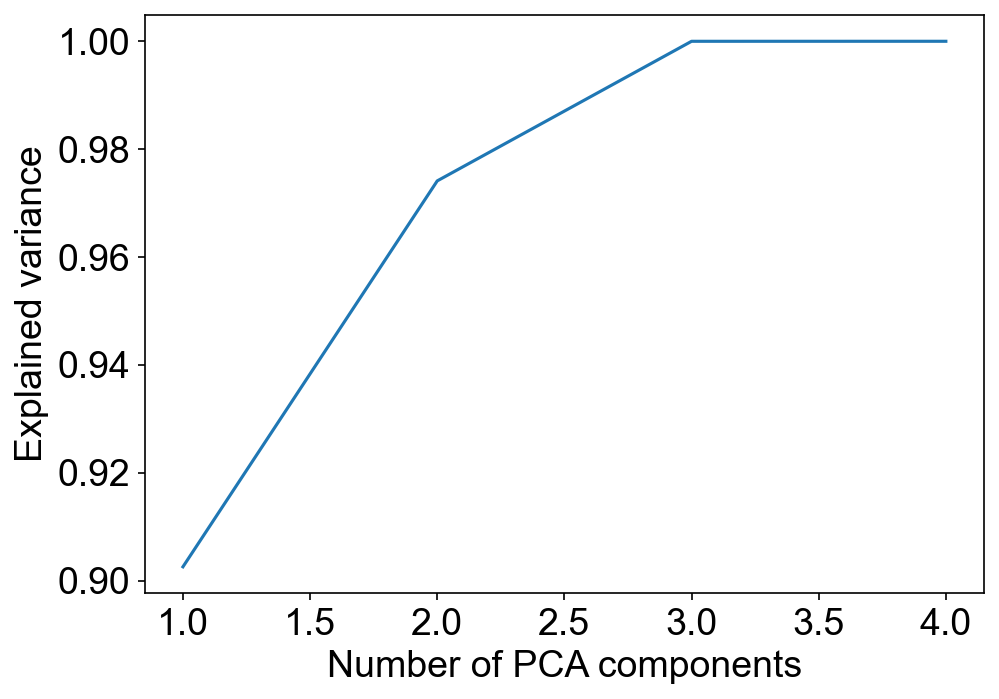

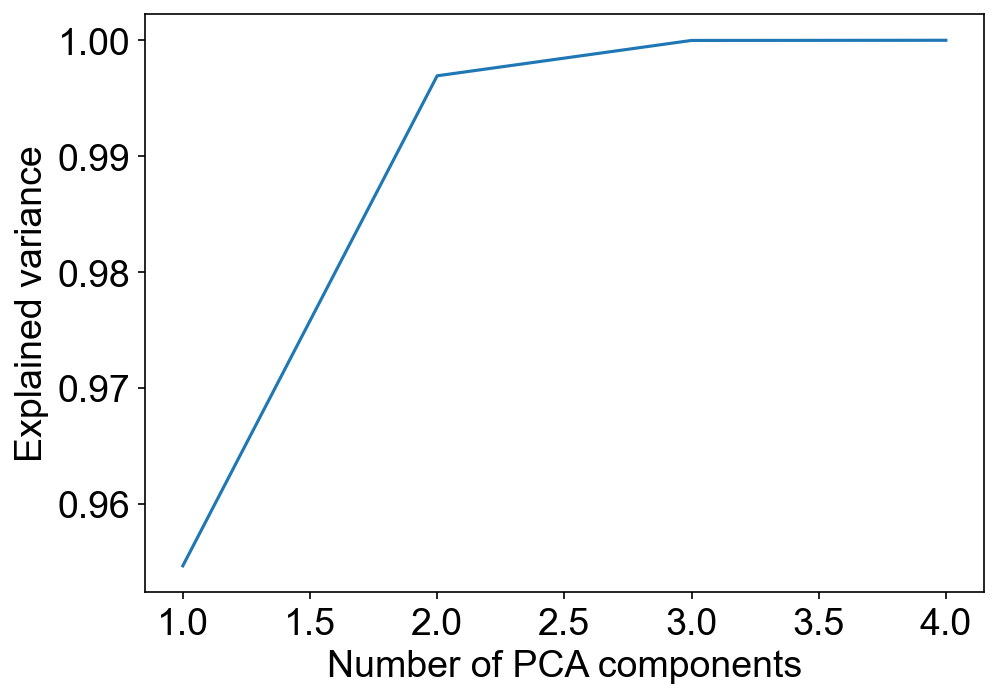

In [57]:
features = [
    "var_q_1c_c100_c10_ah",
    "form_total_lithium_consumed",
    "form_final_discharge_capacity_ah",
    "form_coulombic_efficiency",
    "dcr_10s_5_soc_at_c3",
]
for df_, temp in [(df_hot,"hot"), (df_room,"room")]:
    pca = PCA()
    pca.fit(df_[features[1:]])
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    fig, ax = plt.subplots()
    ax.plot(range(1,len(cumsum)+1),cumsum)
    ax.set_xlabel("Number of PCA components")
    ax.set_ylabel("Explained variance")
    fig.savefig(OUTPUT_DIR + f"pca_paper_features_{temp}.pdf")

In [58]:
for df_, temp in [(df_hot,"hot"), (df_room,"room")]:
    print(temp)
    out = train_and_test_model(df_, features[0], yvar70, to_plot=0, model=DummyRegressor(), num_experiments=1000)
    print(f"{'Dummy regressor (predict mean)':<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    for f in features:
        out = train_and_test_model(df_, f, yvar70, to_plot=0, model=LinearRegression(), num_experiments=1000)
        print(f"{f:<50}"
             +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
             +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    f = "form features"
    out = train_and_test_model(df_, features[1:-1], yvar70, to_plot=0, model=Ridge(5), num_experiments=1000)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    f = "form features + R10s"
    out = train_and_test_model(df_, features[1:], yvar70, to_plot=0, model=Ridge(5), num_experiments=1000)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

hot
Dummy regressor (predict mean)                    train: 14.05 (0.88 std)		test: 14.98 (3.49 std)
var_q_1c_c100_c10_ah                              train: 10.05 (1.14 std)		test: 11.54 (4.14 std)
form_total_lithium_consumed                       train: 14.00 (0.97 std)		test: 15.91 (3.72 std)
form_final_discharge_capacity_ah                  train: 13.08 (0.90 std)		test: 14.65 (3.64 std)
form_coulombic_efficiency                         train: 13.97 (0.97 std)		test: 15.95 (3.67 std)
dcr_10s_5_soc_at_c3                               train: 6.37 (0.66 std)		test: 7.46 (2.64 std)
form features                                     train: 12.88 (0.96 std)		test: 14.81 (4.11 std)
form features + R10s                              train: 6.81 (0.50 std)		test: 8.35 (2.26 std)
room
Dummy regressor (predict mean)                    train: 13.28 (0.94 std)		test: 14.43 (3.85 std)
var_q_1c_c100_c10_ah                              train: 10.91 (1.44 std)		test: 13.26 (4.44 std)
form_total_lith